# Analisi su multi asset

Architettura di un Hammer e di una Shooting Star su paniere senza conferma.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ffn
import datetime

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline

def load_historical_complete_ffn(tickerlist, startdate, enddate):
    inner_tickerlist =  list(tickerlist.split(","))
    input_string = ""
    for ticker in inner_tickerlist:
        if ticker != "^VIX":
            input_string = input_string + ticker + ":Open," +  \
                                          ticker + ":High," + \
                                          ticker + ":Low," + \
                                          ticker + ":Close," +\
                                          ticker + ":Volume,"
        else:
            input_string = input_string + ticker + ":Open," +  \
                                          ticker + ":High," + \
                                          ticker + ":Low," + \
                                          ticker + ":Close,"
    input_string = input_string[:-1]
    print(input_string)
    #'aapl:Open,aapl:High,aapl:Low,aapl:Close'
    dataset = ffn.get(input_string, start = startdate, end = enddate).apply(lambda x: round(x,2))
    dataset.to_csv("universe_data.csv")
    return dataset

def load_historical_from_csv(filename):
    dataset = pd.read_csv(filename, parse_dates=["Date"])
    dataset.index = dataset.Date
    dataset.drop('Date', axis = 1, inplace = True)
    return dataset

def add_indicators(dataframe):
    service = dataframe.copy()
    service.columns = ["open","high","low","close","volume"]
    service["range_perc"] = (service.high - service.low) / service.low * 100
    service["open_pos"] = (service.open - service.low) / (service.high - service.low) * 100
    service["close_pos"] = (service.close - service.low) / (service.high - service.low) * 100
    service["SMA20"] = service.close.rolling(20).mean()
    service["STD20"] = service.close.rolling(20).std()
    service["BBU"] = service.SMA20 + 2 * service.STD20
    service["BBL"] = service.SMA20 - 2 * service.STD20
    service.dropna(inplace = True)
    #print(service.head(10))
    return service

def pattern_stats(dataframe,pattern,direction,delay,ticker):
    """
    Function to calculate pattern stats
    """
    service = dataframe.copy()
    dates = service[pattern == True].index
    occurrences = service[pattern == True].count()[0]
    print("Occurrences:", occurrences, "\n")
    print(dates,"\n")
    results = []
    for i in range(0, delay):
        label = "st" + str(i + 1)
        if direction == "long":
            service[label] = np.where(pattern.shift(1) == True, service.close.shift(-i) - service.open, np.nan)
        else:
            service[label] = np.where(pattern.shift(1) == True, -service.close.shift(-i) + service.open, np.nan)
        profit = round(service[label].sum(),2)
        avg_profit = round(profit / occurrences, 2)
        winning_trades = service[service[label] > 0].count()[0]
        loosing_trades = service[service[label] <= 0].count()[0]
        print("After:", i + 1,  "days:", profit, "average of", avg_profit, "with", winning_trades, "winning trades and", loosing_trades, "loosing trades")
        results.append(profit)
    plotting_results = pd.DataFrame(results, columns = ["results"], 
                                    index = range(1, delay + 1))
    plotting_results.plot(figsize = [14,8], color = "blue").grid()
    plt.title(ticker + " post pattern inertia")
    plt.show()
    return dates, plotting_results

def plot_patterns(dataframe,results):
    """
    Function that plots every single pattern occurrence
    """
    for date in results:
        single_case = dataframe[(dataframe.index >= (date)) & \
                                (dataframe.index <= (date + pd.Timedelta(days = 20)))]    
        graph_title = ticker + " from " + str(single_case.index[0]) + " - Powered by Gandalf Project R&D"

        #up_colors = np.where(single_case.index == date, "yellow", "green")
        #down_colors = np.where(single_case.index == date, "yellow", "red")

        single_case.iplot(kind = 'candle',theme = 'white',
                          up_color = "green", down_color = "red",
                          title = graph_title, xTitle = "Time", yTitle = "Prices")
    return

def create_asset_dataset(matrix):
    """
    Function that slices the original dataframe
    for each single asset
    """
    service = pd.DataFrame(index = matrix.index)
    for column in matrix.columns:
        #print(column)
        if ticker.lower() in column:
            service[column] = matrix[column]
    service = add_indicators(service)
    #print(service)
    return service

def positive_effect(basket_results):
    export = []
    for i in range(1, len(basket_results) + 1):
        positive = []
        for column in basket_results.columns:
            if basket_results[column][i] > 0:
                positive.append(column)
        export.append(positive)
        print("Positive inertia after", i, "bars:", positive)
    return export

In [3]:
load_new_data = True
tickerlist = "MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,XOM,GS,HD,IBM,INTC,JNJ,JPM,MCD,MSFT,NKE" #,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA,DIS"
startdate = "2010-01-01"
enddate = "2020-11-10"
days_after = 10
show_patterns = False

In [4]:
if load_new_data == True:
    matrix = load_historical_complete_ffn(tickerlist, startdate, enddate)
else:
    matrix = load_historical_from_csv("universe_data.csv")
    #print(matrix)

matrix.to_csv("universe_data.csv")
matrix.head(10)

MMM:Open,MMM:High,MMM:Low,MMM:Close,MMM:Volume,AXP:Open,AXP:High,AXP:Low,AXP:Close,AXP:Volume,AAPL:Open,AAPL:High,AAPL:Low,AAPL:Close,AAPL:Volume,BA:Open,BA:High,BA:Low,BA:Close,BA:Volume,CAT:Open,CAT:High,CAT:Low,CAT:Close,CAT:Volume,CVX:Open,CVX:High,CVX:Low,CVX:Close,CVX:Volume,CSCO:Open,CSCO:High,CSCO:Low,CSCO:Close,CSCO:Volume,KO:Open,KO:High,KO:Low,KO:Close,KO:Volume,XOM:Open,XOM:High,XOM:Low,XOM:Close,XOM:Volume,GS:Open,GS:High,GS:Low,GS:Close,GS:Volume,HD:Open,HD:High,HD:Low,HD:Close,HD:Volume,IBM:Open,IBM:High,IBM:Low,IBM:Close,IBM:Volume,INTC:Open,INTC:High,INTC:Low,INTC:Close,INTC:Volume,JNJ:Open,JNJ:High,JNJ:Low,JNJ:Close,JNJ:Volume,JPM:Open,JPM:High,JPM:Low,JPM:Close,JPM:Volume,MCD:Open,MCD:High,MCD:Low,MCD:Close,MCD:Volume,MSFT:Open,MSFT:High,MSFT:Low,MSFT:Close,MSFT:Volume,NKE:Open,NKE:High,NKE:Low,NKE:Close,NKE:Volume


,mmmopen,mmmhigh,mmmlow,mmmclose,mmmvolume,axpopen,axphigh,axplow,axpclose,axpvolume,...,msftopen,msfthigh,msftlow,msftclose,msftvolume,nkeopen,nkehigh,nkelow,nkeclose,nkevolume
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,83.09,83.45,82.67,83.02,3043700.0,40.81,41.10,40.39,40.92,6894300.0,...,30.62,31.10,30.59,30.95,38409100.0,16.51,16.52,16.28,16.34,11972400.0
2010-01-05,82.80,83.23,81.70,82.50,2847000.0,40.83,41.23,40.37,40.83,10641200.0,...,30.85,31.10,30.64,30.96,49749600.0,16.28,16.45,16.17,16.40,6275200.0
2010-01-06,83.88,84.60,83.51,83.67,5268500.0,41.23,41.67,41.17,41.49,8399400.0,...,30.88,31.08,30.52,30.77,58182400.0,16.35,16.42,16.24,16.30,13399200.0
2010-01-07,83.32,83.76,82.12,83.73,4470100.0,41.26,42.24,41.11,41.98,8981700.0,...,30.63,30.70,30.19,30.45,50559700.0,16.28,16.50,16.26,16.46,7187600.0
2010-01-08,83.69,84.32,83.30,84.32,3405800.0,41.76,42.48,41.40,41.95,7907700.0,...,30.28,30.88,30.24,30.66,51197400.0,16.45,16.46,16.24,16.43,7249600.0
2010-01-11,84.38,84.60,83.41,83.98,2927100.0,41.74,41.96,41.25,41.47,7396000.0,...,30.71,30.76,30.12,30.27,68754700.0,16.48,16.48,16.16,16.23,10678000.0
2010-01-12,83.58,84.18,83.30,84.05,3031800.0,41.27,42.35,41.25,42.02,12657300.0,...,30.15,30.40,29.91,30.07,65912100.0,16.15,16.27,16.07,16.20,11485600.0
2010-01-13,84.11,84.11,83.20,83.78,3102000.0,41.85,42.24,41.57,42.15,10137200.0,...,30.26,30.52,30.01,30.35,51863500.0,16.28,16.42,16.19,16.35,5648800.0
2010-01-14,83.74,83.93,83.42,83.50,2634100.0,42.04,42.74,42.02,42.68,8238400.0,...,30.31,31.10,30.26,30.96,63228100.0,16.37,16.46,16.19,16.25,7311600.0


# <span style="color:green">Esempio pattern "Hammer"</span>

Pattern analysis on: MMM

Occurrences: 13 

DatetimeIndex(['2010-05-06', '2010-06-08', '2010-08-18', '2010-11-03',
               '2013-04-29', '2014-09-26', '2015-07-07', '2016-06-27',
               '2018-01-03', '2018-02-09', '2018-12-10', '2020-03-13',
               '2020-05-14'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 4.4 average of 0.34 with 8 winning trades and 5 loosing trades
After: 2 days: 31.32 average of 2.41 with 10 winning trades and 3 loosing trades
After: 3 days: 38.86 average of 2.99 with 10 winning trades and 3 loosing trades
After: 4 days: 42.25 average of 3.25 with 9 winning trades and 4 loosing trades
After: 5 days: 28.08 average of 2.16 with 8 winning trades and 5 loosing trades
After: 6 days: 21.57 average of 1.66 with 9 winning trades and 4 loosing trades
After: 7 days: 36.25 average of 2.79 with 9 winning trades and 4 loosing trades
After: 8 days: 47.97 average of 3.69 with 10 winning trades and 3 loosing trades
After: 9

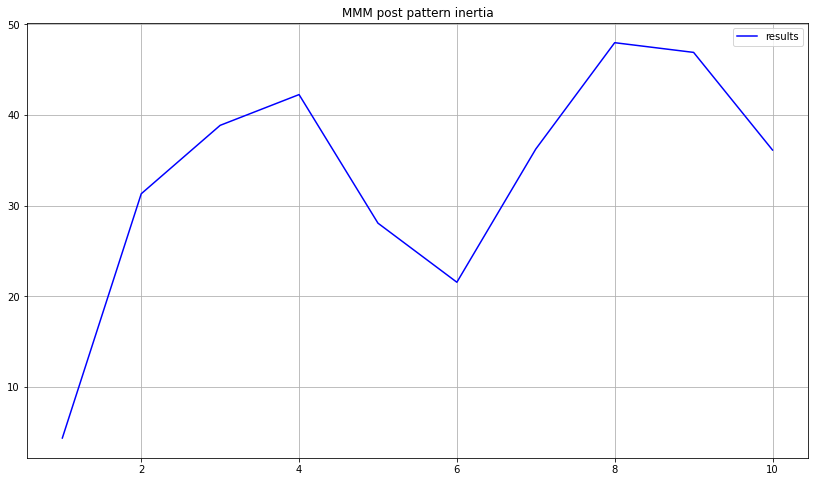


Pattern analysis on: AXP

Occurrences: 9 

DatetimeIndex(['2010-05-17', '2011-10-05', '2012-05-23', '2013-04-17',
               '2014-07-28', '2015-07-07', '2017-05-31', '2018-12-10',
               '2020-10-30'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.82 average of -0.09 with 5 winning trades and 4 loosing trades
After: 2 days: 4.97 average of 0.55 with 5 winning trades and 4 loosing trades
After: 3 days: 3.48 average of 0.39 with 6 winning trades and 3 loosing trades
After: 4 days: 4.96 average of 0.55 with 5 winning trades and 4 loosing trades
After: 5 days: 1.71 average of 0.19 with 5 winning trades and 4 loosing trades
After: 6 days: 18.94 average of 2.1 with 5 winning trades and 4 loosing trades
After: 7 days: 14.69 average of 1.63 with 5 winning trades and 4 loosing trades
After: 8 days: -9.99 average of -1.11 with 4 winning trades and 4 loosing trades
After: 9 days: -9.2 average of -1.02 with 4 winning trades and 4 loosing trades
Aft

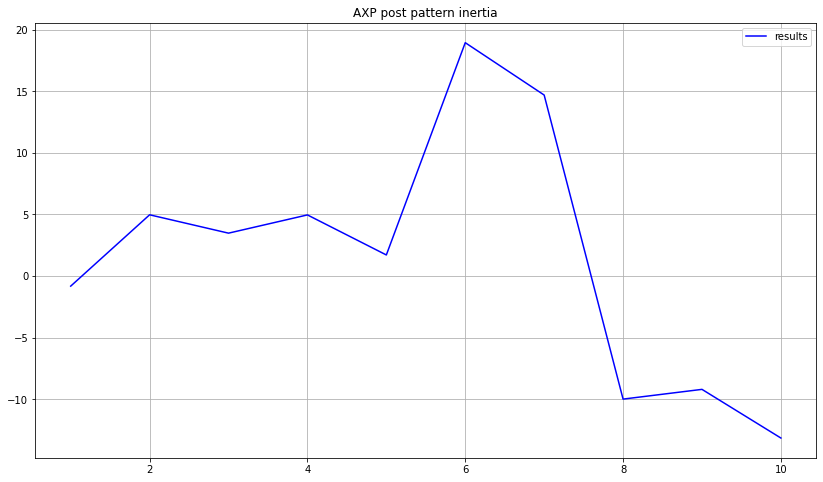


Pattern analysis on: AAPL

Occurrences: 11 

DatetimeIndex(['2010-05-06', '2010-08-27', '2012-10-09', '2012-11-16',
               '2015-07-07', '2015-10-01', '2015-12-16', '2015-12-21',
               '2018-02-09', '2019-05-10', '2020-03-23'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 3.22 average of 0.29 with 6 winning trades and 5 loosing trades
After: 2 days: 3.14 average of 0.29 with 8 winning trades and 3 loosing trades
After: 3 days: 9.25 average of 0.84 with 8 winning trades and 3 loosing trades
After: 4 days: 8.71 average of 0.79 with 8 winning trades and 3 loosing trades
After: 5 days: 11.83 average of 1.08 with 10 winning trades and 1 loosing trades
After: 6 days: 9.98 average of 0.91 with 8 winning trades and 3 loosing trades
After: 7 days: 6.51 average of 0.59 with 7 winning trades and 4 loosing trades
After: 8 days: 7.08 average of 0.64 with 7 winning trades and 4 loosing trades
After: 9 days: 5.98 average of 0.54 with 7 winning trade

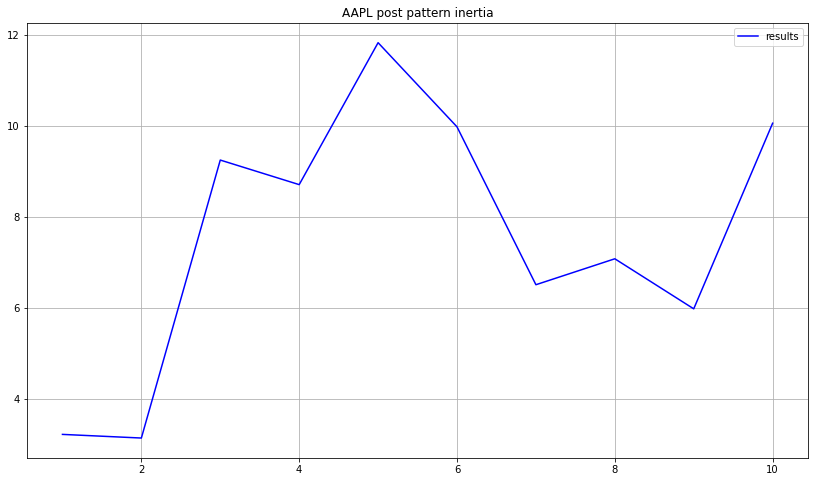


Pattern analysis on: BA

Occurrences: 17 

DatetimeIndex(['2013-06-21', '2014-02-05', '2014-10-15', '2015-08-12',
               '2015-08-26', '2015-09-24', '2016-01-06', '2016-01-12',
               '2016-01-14', '2016-06-01', '2016-09-01', '2018-02-09',
               '2018-03-16', '2018-03-28', '2019-06-03', '2020-03-10',
               '2020-09-04'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -24.13 average of -1.42 with 10 winning trades and 7 loosing trades
After: 2 days: -47.01 average of -2.77 with 10 winning trades and 7 loosing trades
After: 3 days: -25.71 average of -1.51 with 10 winning trades and 7 loosing trades
After: 4 days: -58.94 average of -3.47 with 9 winning trades and 8 loosing trades
After: 5 days: -67.51 average of -3.97 with 8 winning trades and 9 loosing trades
After: 6 days: -97.27 average of -5.72 with 9 winning trades and 8 loosing trades
After: 7 days: -119.94 average of -7.06 with 9 winning trades and 8 loosing trades


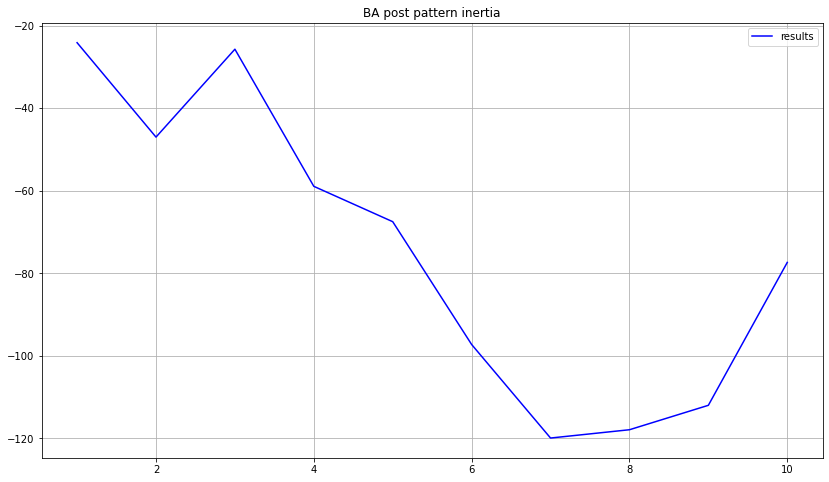


Pattern analysis on: CAT

Occurrences: 11 

DatetimeIndex(['2010-10-27', '2011-08-05', '2012-05-08', '2014-09-11',
               '2014-09-18', '2015-01-29', '2015-08-26', '2018-02-09',
               '2019-10-03', '2020-03-13', '2020-05-13'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 5.02 average of 0.46 with 8 winning trades and 3 loosing trades
After: 2 days: 19.01 average of 1.73 with 8 winning trades and 3 loosing trades
After: 3 days: 27.26 average of 2.48 with 7 winning trades and 4 loosing trades
After: 4 days: 29.75 average of 2.7 with 6 winning trades and 5 loosing trades
After: 5 days: 28.66 average of 2.61 with 8 winning trades and 3 loosing trades
After: 6 days: 29.43 average of 2.68 with 7 winning trades and 4 loosing trades
After: 7 days: 29.21 average of 2.66 with 7 winning trades and 4 loosing trades
After: 8 days: 41.23 average of 3.75 with 7 winning trades and 4 loosing trades
After: 9 days: 50.52 average of 4.59 with 6 winning t

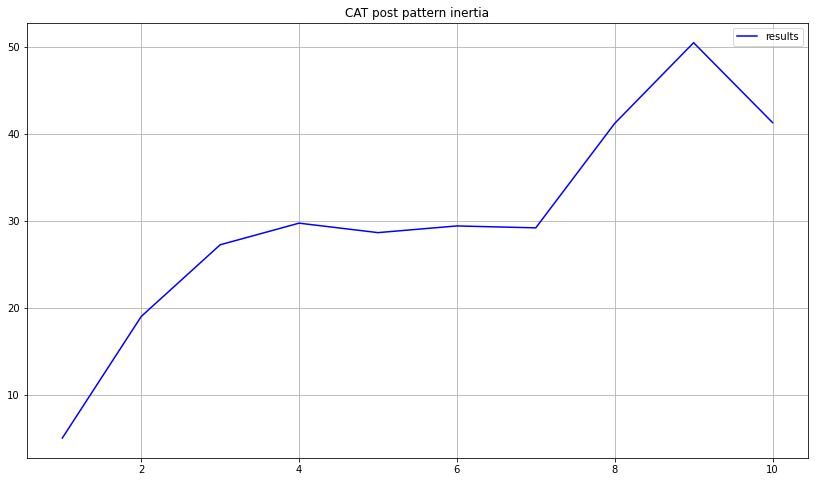


Pattern analysis on: CVX

Occurrences: 21 

DatetimeIndex(['2010-05-17', '2011-04-18', '2011-06-23', '2012-05-23',
               '2013-06-21', '2013-10-02', '2014-08-04', '2014-09-29',
               '2014-10-03', '2016-01-12', '2016-01-20', '2016-08-02',
               '2018-01-31', '2018-02-01', '2018-02-09', '2018-07-18',
               '2018-12-06', '2018-12-10', '2019-10-04', '2020-01-09',
               '2020-03-10'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -16.65 average of -0.79 with 7 winning trades and 14 loosing trades
After: 2 days: -32.28 average of -1.54 with 5 winning trades and 16 loosing trades
After: 3 days: -27.63 average of -1.32 with 10 winning trades and 11 loosing trades
After: 4 days: -38.9 average of -1.85 with 8 winning trades and 13 loosing trades
After: 5 days: -42.94 average of -2.04 with 7 winning trades and 14 loosing trades
After: 6 days: -69.92 average of -3.33 with 7 winning trades and 14 loosing trades
After: 7

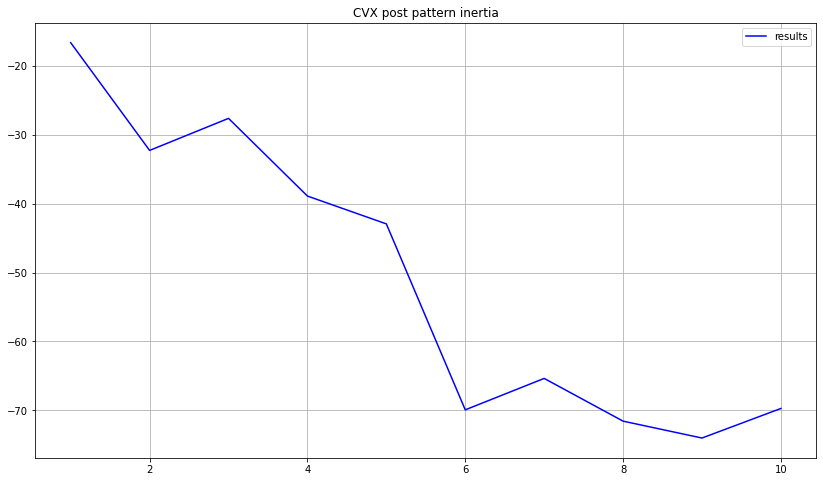


Pattern analysis on: CSCO

Occurrences: 11 

DatetimeIndex(['2010-05-17', '2011-05-18', '2013-02-14', '2013-10-24',
               '2014-10-08', '2016-01-04', '2017-06-16', '2018-04-03',
               '2018-07-23', '2019-10-10', '2019-11-18'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.21 average of -0.02 with 5 winning trades and 6 loosing trades
After: 2 days: -0.66 average of -0.06 with 4 winning trades and 7 loosing trades
After: 3 days: -3.53 average of -0.32 with 5 winning trades and 6 loosing trades
After: 4 days: -4.5 average of -0.41 with 5 winning trades and 6 loosing trades
After: 5 days: -2.27 average of -0.21 with 4 winning trades and 7 loosing trades
After: 6 days: -2.83 average of -0.26 with 4 winning trades and 7 loosing trades
After: 7 days: -2.79 average of -0.25 with 2 winning trades and 9 loosing trades
After: 8 days: -0.28 average of -0.03 with 6 winning trades and 5 loosing trades
After: 9 days: -2.67 average of -0.24 with 

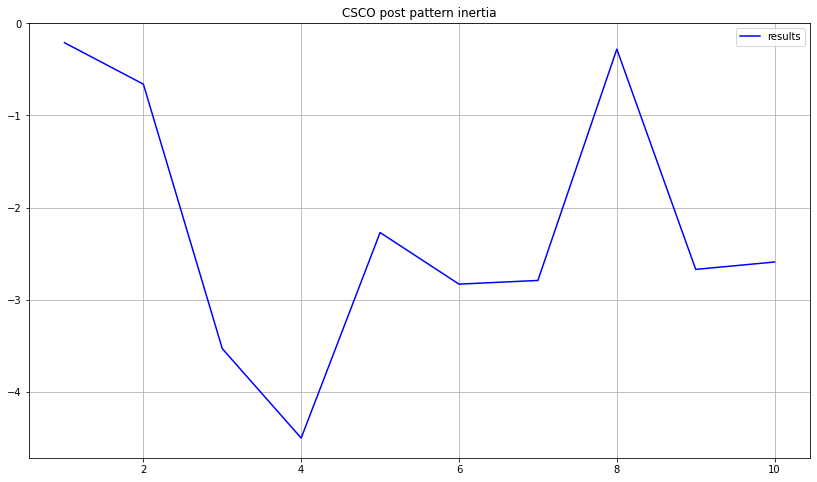


Pattern analysis on: KO

Occurrences: 12 

DatetimeIndex(['2011-10-05', '2013-05-23', '2013-07-26', '2013-10-01',
               '2015-08-26', '2016-01-20', '2016-06-28', '2017-12-11',
               '2018-12-10', '2020-03-10', '2020-03-11', '2020-03-18'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -4.17 average of -0.35 with 4 winning trades and 8 loosing trades
After: 2 days: -9.07 average of -0.76 with 5 winning trades and 7 loosing trades
After: 3 days: -12.42 average of -1.03 with 5 winning trades and 7 loosing trades
After: 4 days: -12.47 average of -1.04 with 4 winning trades and 8 loosing trades
After: 5 days: -12.55 average of -1.05 with 4 winning trades and 8 loosing trades
After: 6 days: -13.82 average of -1.15 with 5 winning trades and 7 loosing trades
After: 7 days: -20.71 average of -1.73 with 4 winning trades and 8 loosing trades
After: 8 days: -24.4 average of -2.03 with 5 winning trades and 7 loosing trades
After: 9 days: -24.93 ave

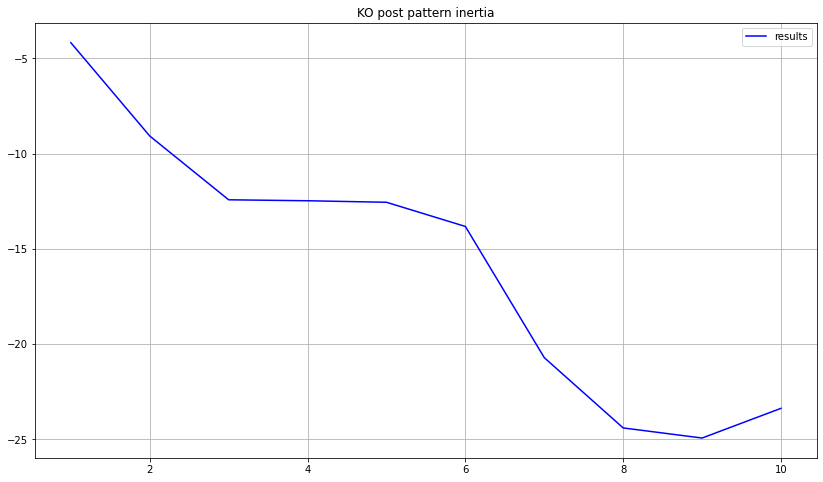


Pattern analysis on: XOM

Occurrences: 15 

DatetimeIndex(['2011-06-23', '2011-08-09', '2012-05-23', '2012-10-15',
               '2012-12-27', '2013-08-01', '2016-06-27', '2016-08-31',
               '2017-05-26', '2017-07-28', '2018-02-09', '2018-07-30',
               '2019-05-07', '2019-05-24', '2019-07-22'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -5.72 average of -0.38 with 7 winning trades and 8 loosing trades
After: 2 days: 0.43 average of 0.03 with 8 winning trades and 7 loosing trades
After: 3 days: 6.45 average of 0.43 with 8 winning trades and 7 loosing trades
After: 4 days: 1.93 average of 0.13 with 7 winning trades and 8 loosing trades
After: 5 days: 4.38 average of 0.29 with 8 winning trades and 7 loosing trades
After: 6 days: 3.34 average of 0.22 with 7 winning trades and 8 loosing trades
After: 7 days: -5.15 average of -0.34 with 6 winning trades and 9 loosing trades
After: 8 days: -8.83 average of -0.59 with 5 winning trades and

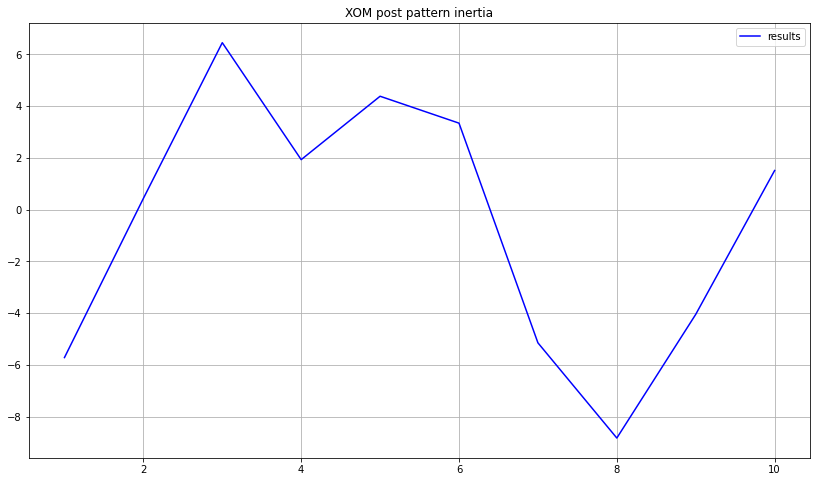


Pattern analysis on: GS

Occurrences: 14 

DatetimeIndex(['2011-03-17', '2011-08-09', '2014-10-15', '2014-12-01',
               '2015-07-07', '2016-02-03', '2016-09-28', '2018-02-09',
               '2018-05-03', '2018-05-30', '2019-03-07', '2019-05-23',
               '2019-05-29', '2020-10-30'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -1.31 average of -0.09 with 8 winning trades and 6 loosing trades
After: 2 days: 21.96 average of 1.57 with 9 winning trades and 5 loosing trades
After: 3 days: 26.1 average of 1.86 with 9 winning trades and 5 loosing trades
After: 4 days: 56.47 average of 4.03 with 10 winning trades and 4 loosing trades
After: 5 days: 55.3 average of 3.95 with 11 winning trades and 3 loosing trades
After: 6 days: 66.75 average of 4.77 with 11 winning trades and 3 loosing trades
After: 7 days: 78.76 average of 5.63 with 10 winning trades and 4 loosing trades
After: 8 days: 59.29 average of 4.24 with 10 winning trades and 3 loosin

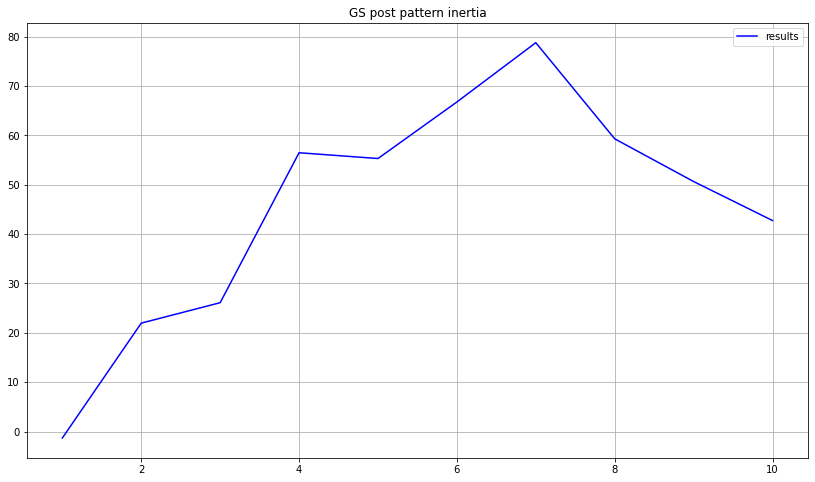


Pattern analysis on: HD

Occurrences: 6 

DatetimeIndex(['2010-05-19', '2014-04-15', '2014-05-15', '2016-10-19',
               '2018-02-09', '2020-09-21'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.6 average of -0.1 with 4 winning trades and 2 loosing trades
After: 2 days: -7.57 average of -1.26 with 2 winning trades and 4 loosing trades
After: 3 days: -3.74 average of -0.62 with 3 winning trades and 3 loosing trades
After: 4 days: -2.16 average of -0.36 with 3 winning trades and 3 loosing trades
After: 5 days: 2.3 average of 0.38 with 5 winning trades and 1 loosing trades
After: 6 days: 3.53 average of 0.59 with 5 winning trades and 1 loosing trades
After: 7 days: 6.23 average of 1.04 with 4 winning trades and 2 loosing trades
After: 8 days: 7.44 average of 1.24 with 3 winning trades and 3 loosing trades
After: 9 days: 9.79 average of 1.63 with 5 winning trades and 1 loosing trades
After: 10 days: 12.97 average of 2.16 with 4 winning trades an

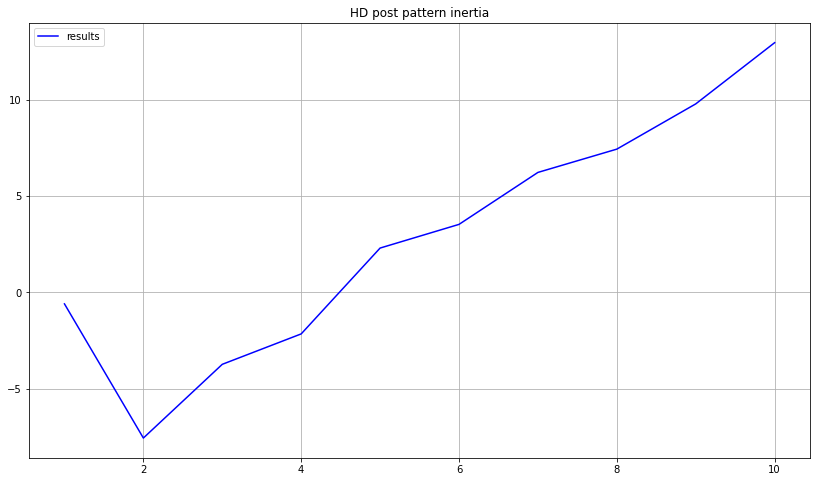


Pattern analysis on: IBM

Occurrences: 21 

DatetimeIndex(['2011-08-05', '2012-01-13', '2012-05-23', '2013-04-05',
               '2013-06-25', '2014-05-07', '2015-02-02', '2015-06-09',
               '2015-06-15', '2015-07-07', '2015-12-21', '2016-10-13',
               '2017-07-11', '2017-07-27', '2019-05-10', '2019-08-07',
               '2019-10-03', '2019-12-03', '2020-03-10', '2020-03-13',
               '2020-09-21'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 1.64 average of 0.08 with 11 winning trades and 10 loosing trades
After: 2 days: -5.36 average of -0.26 with 12 winning trades and 9 loosing trades
After: 3 days: -12.06 average of -0.57 with 14 winning trades and 7 loosing trades
After: 4 days: -10.1 average of -0.48 with 10 winning trades and 11 loosing trades
After: 5 days: -9.35 average of -0.45 with 12 winning trades and 9 loosing trades
After: 6 days: -15.25 average of -0.73 with 13 winning trades and 8 loosing trades
After: 7 day

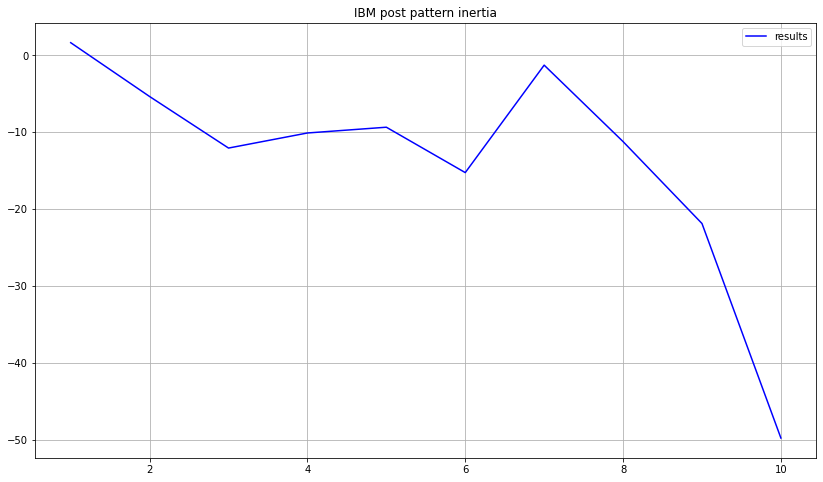


Pattern analysis on: INTC

Occurrences: 14 

DatetimeIndex(['2010-06-08', '2011-01-07', '2012-05-21', '2012-05-23',
               '2013-04-05', '2013-05-24', '2013-06-25', '2013-07-10',
               '2014-09-26', '2015-02-03', '2015-07-07', '2016-01-04',
               '2017-03-14', '2017-12-01'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.09 average of 0.01 with 6 winning trades and 8 loosing trades
After: 2 days: -0.7 average of -0.05 with 9 winning trades and 5 loosing trades
After: 3 days: -1.46 average of -0.1 with 8 winning trades and 6 loosing trades
After: 4 days: -2.3 average of -0.16 with 8 winning trades and 6 loosing trades
After: 5 days: 0.31 average of 0.02 with 9 winning trades and 5 loosing trades
After: 6 days: -0.16 average of -0.01 with 7 winning trades and 7 loosing trades
After: 7 days: -1.66 average of -0.12 with 7 winning trades and 7 loosing trades
After: 8 days: -2.0 average of -0.14 with 8 winning trades and 6 loosing 

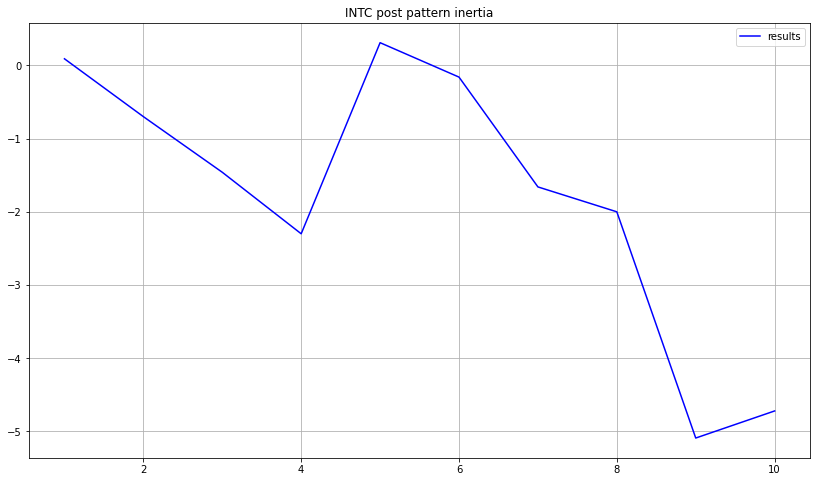


Pattern analysis on: JNJ

Occurrences: 12 

DatetimeIndex(['2011-06-23', '2011-08-09', '2012-01-20', '2012-04-17',
               '2015-02-02', '2015-08-12', '2017-07-27', '2018-07-02',
               '2019-05-15', '2019-09-27', '2020-03-24', '2020-06-25'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.33 average of -0.03 with 6 winning trades and 6 loosing trades
After: 2 days: 14.67 average of 1.22 with 7 winning trades and 5 loosing trades
After: 3 days: 18.85 average of 1.57 with 10 winning trades and 2 loosing trades
After: 4 days: 27.2 average of 2.27 with 10 winning trades and 2 loosing trades
After: 5 days: 30.4 average of 2.53 with 10 winning trades and 2 loosing trades
After: 6 days: 30.85 average of 2.57 with 11 winning trades and 1 loosing trades
After: 7 days: 30.54 average of 2.54 with 10 winning trades and 2 loosing trades
After: 8 days: 20.26 average of 1.69 with 9 winning trades and 3 loosing trades
After: 9 days: 18.66 average of 1

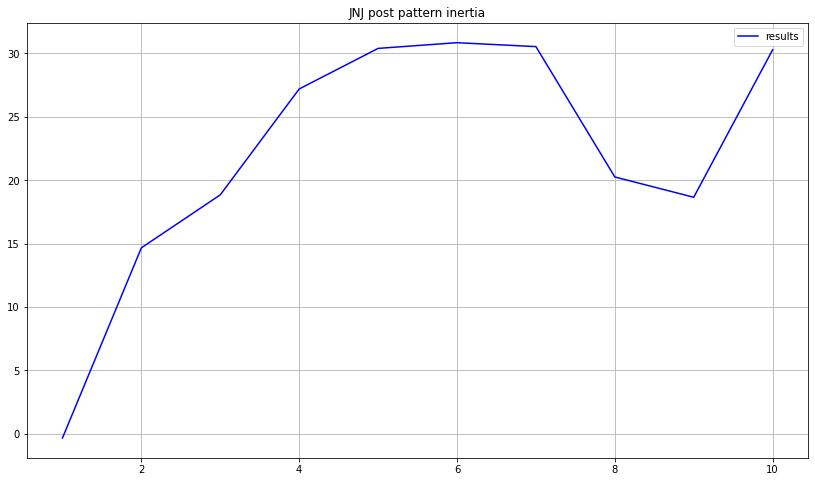


Pattern analysis on: JPM

Occurrences: 11 

DatetimeIndex(['2010-05-14', '2010-05-17', '2011-03-17', '2011-07-18',
               '2012-11-16', '2015-07-07', '2015-09-29', '2016-06-28',
               '2018-05-03', '2018-06-26', '2020-10-30'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 1.74 average of 0.16 with 7 winning trades and 4 loosing trades
After: 2 days: 9.71 average of 0.88 with 9 winning trades and 2 loosing trades
After: 3 days: 6.9 average of 0.63 with 8 winning trades and 3 loosing trades
After: 4 days: 15.9 average of 1.45 with 8 winning trades and 3 loosing trades
After: 5 days: 15.75 average of 1.43 with 8 winning trades and 3 loosing trades
After: 6 days: 28.63 average of 2.6 with 8 winning trades and 3 loosing trades
After: 7 days: 29.82 average of 2.71 with 8 winning trades and 3 loosing trades
After: 8 days: 16.87 average of 1.53 with 8 winning trades and 2 loosing trades
After: 9 days: 18.15 average of 1.65 with 9 winning trade

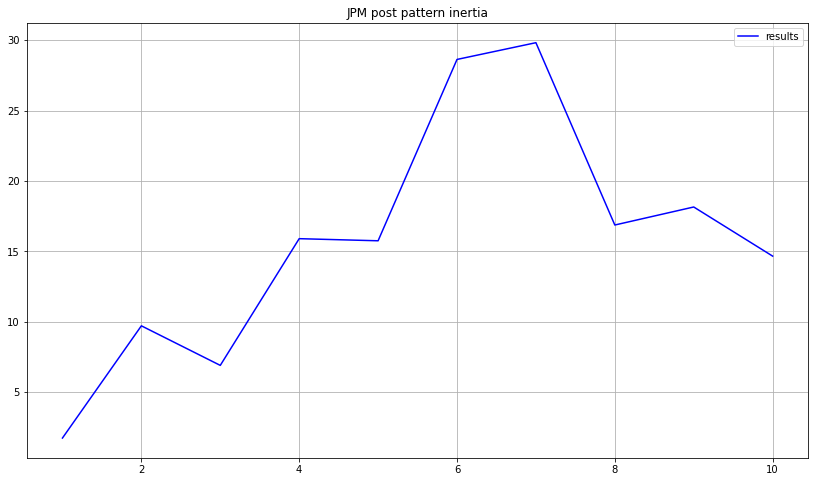


Pattern analysis on: MCD

Occurrences: 8 

DatetimeIndex(['2010-07-01', '2011-01-07', '2011-08-05', '2013-06-06',
               '2015-04-02', '2018-02-09', '2019-02-04', '2020-03-13'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -7.77 average of -0.97 with 3 winning trades and 5 loosing trades
After: 2 days: -6.57 average of -0.82 with 4 winning trades and 4 loosing trades
After: 3 days: -21.98 average of -2.75 with 4 winning trades and 4 loosing trades
After: 4 days: -6.83 average of -0.85 with 4 winning trades and 4 loosing trades
After: 5 days: -7.62 average of -0.95 with 4 winning trades and 4 loosing trades
After: 6 days: -19.09 average of -2.39 with 5 winning trades and 3 loosing trades
After: 7 days: 9.3 average of 1.16 with 6 winning trades and 2 loosing trades
After: 8 days: 14.64 average of 1.83 with 6 winning trades and 2 loosing trades
After: 9 days: 22.15 average of 2.77 with 7 winning trades and 1 loosing trades
After: 10 days: 16.44 a

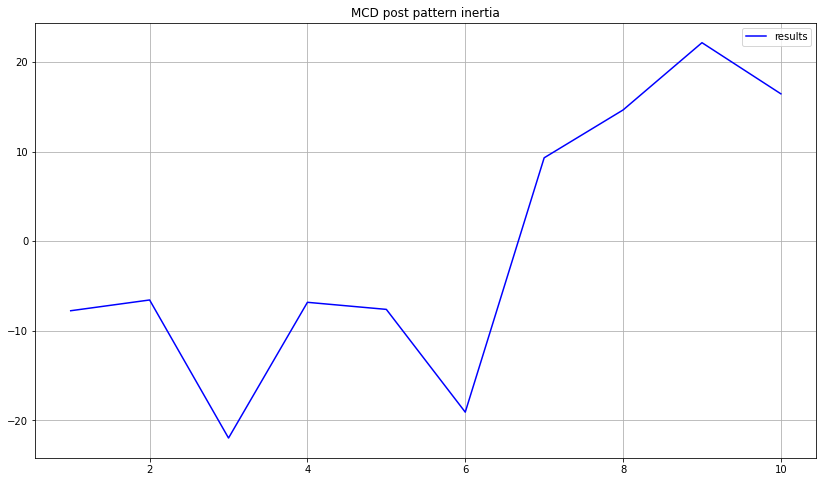


Pattern analysis on: MSFT

Occurrences: 10 

DatetimeIndex(['2010-02-01', '2011-02-14', '2011-02-16', '2013-08-15',
               '2013-12-18', '2014-05-07', '2015-07-07', '2016-02-08',
               '2016-10-12', '2018-10-30'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 1.95 average of 0.2 with 7 winning trades and 3 loosing trades
After: 2 days: 2.39 average of 0.24 with 8 winning trades and 2 loosing trades
After: 3 days: 1.91 average of 0.19 with 7 winning trades and 3 loosing trades
After: 4 days: 6.37 average of 0.64 with 7 winning trades and 3 loosing trades
After: 5 days: 7.49 average of 0.75 with 7 winning trades and 3 loosing trades
After: 6 days: 14.56 average of 1.46 with 7 winning trades and 3 loosing trades
After: 7 days: 17.25 average of 1.72 with 7 winning trades and 3 loosing trades
After: 8 days: 14.64 average of 1.46 with 7 winning trades and 3 loosing trades
After: 9 days: 12.26 average of 1.23 with 7 winning trades and 3 loosi

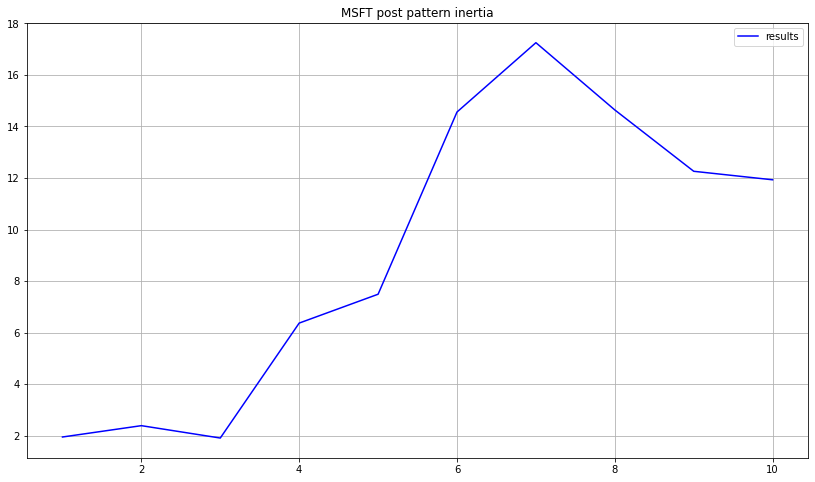


Pattern analysis on: NKE

Occurrences: 9 

DatetimeIndex(['2010-05-19', '2012-06-04', '2012-06-18', '2013-05-24',
               '2014-06-13', '2015-08-12', '2016-05-06', '2017-05-11',
               '2019-05-06'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.06 average of -0.01 with 5 winning trades and 4 loosing trades
After: 2 days: 1.26 average of 0.14 with 5 winning trades and 4 loosing trades
After: 3 days: -1.69 average of -0.19 with 4 winning trades and 5 loosing trades
After: 4 days: -0.55 average of -0.06 with 5 winning trades and 4 loosing trades
After: 5 days: -3.18 average of -0.35 with 4 winning trades and 5 loosing trades
After: 6 days: -2.76 average of -0.31 with 4 winning trades and 5 loosing trades
After: 7 days: -7.92 average of -0.88 with 3 winning trades and 6 loosing trades
After: 8 days: -9.71 average of -1.08 with 3 winning trades and 6 loosing trades
After: 9 days: -9.77 average of -1.09 with 3 winning trades and 6 loosing 

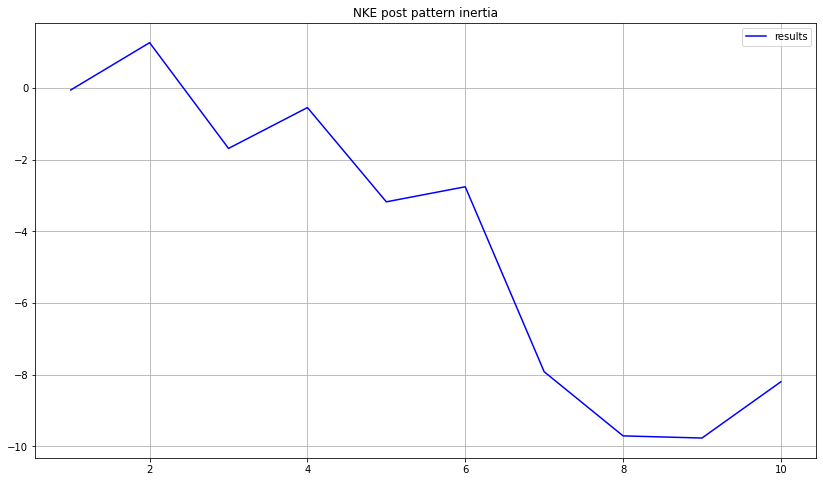


Basket analysis:
Positive inertia after 1 bars: ['MMM', 'AAPL', 'CAT', 'IBM', 'INTC', 'JPM', 'MSFT']
Positive inertia after 2 bars: ['MMM', 'AXP', 'AAPL', 'CAT', 'XOM', 'GS', 'JNJ', 'JPM', 'MSFT', 'NKE']
Positive inertia after 3 bars: ['MMM', 'AXP', 'AAPL', 'CAT', 'XOM', 'GS', 'JNJ', 'JPM', 'MSFT']
Positive inertia after 4 bars: ['MMM', 'AXP', 'AAPL', 'CAT', 'XOM', 'GS', 'JNJ', 'JPM', 'MSFT']
Positive inertia after 5 bars: ['MMM', 'AXP', 'AAPL', 'CAT', 'XOM', 'GS', 'HD', 'INTC', 'JNJ', 'JPM', 'MSFT']
Positive inertia after 6 bars: ['MMM', 'AXP', 'AAPL', 'CAT', 'XOM', 'GS', 'HD', 'JNJ', 'JPM', 'MSFT']
Positive inertia after 7 bars: ['MMM', 'AXP', 'AAPL', 'CAT', 'GS', 'HD', 'JNJ', 'JPM', 'MCD', 'MSFT']
Positive inertia after 8 bars: ['MMM', 'AAPL', 'CAT', 'GS', 'HD', 'JNJ', 'JPM', 'MCD', 'MSFT']
Positive inertia after 9 bars: ['MMM', 'AAPL', 'CAT', 'GS', 'HD', 'JNJ', 'JPM', 'MCD', 'MSFT']
Positive inertia after 10 bars: ['MMM', 'AAPL', 'CAT', 'XOM', 'GS', 'HD', 'JNJ', 'JPM', 'MCD', 'MSF

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,XOM,GS,HD,IBM,INTC,JNJ,JPM,MCD,MSFT,NKE,basket
1,4.40,-0.82,3.22,-24.13,5.02,-16.65,-0.21,-4.17,-5.72,-1.31,-0.60,1.64,0.09,-0.33,1.74,-7.77,1.95,-0.06,-2.428333
2,31.32,4.97,3.14,-47.01,19.01,-32.28,-0.66,-9.07,0.43,21.96,-7.57,-5.36,-0.70,14.67,9.71,-6.57,2.39,1.26,-0.020000
3,38.86,3.48,9.25,-25.71,27.26,-27.63,-3.53,-12.42,6.45,26.10,-3.74,-12.06,-1.46,18.85,6.90,-21.98,1.91,-1.69,1.602222
4,42.25,4.96,8.71,-58.94,29.75,-38.90,-4.50,-12.47,1.93,56.47,-2.16,-10.10,-2.30,27.20,15.90,-6.83,6.37,-0.55,3.155000
5,28.08,1.71,11.83,-67.51,28.66,-42.94,-2.27,-12.55,4.38,55.30,2.30,-9.35,0.31,30.40,15.75,-7.62,7.49,-3.18,2.266111
6,21.57,18.94,9.98,-97.27,29.43,-69.92,-2.83,-13.82,3.34,66.75,3.53,-15.25,-0.16,30.85,28.63,-19.09,14.56,-2.76,0.360000
7,36.25,14.69,6.51,-119.94,29.21,-65.36,-2.79,-20.71,-5.15,78.76,6.23,-1.28,-1.66,30.54,29.82,9.30,17.25,-7.92,1.875000
8,47.97,-9.99,7.08,-117.93,41.23,-71.56,-0.28,-24.40,-8.83,59.29,7.44,-11.22,-2.00,20.26,16.87,14.64,14.64,-9.71,-1.472222
9,46.90,-9.20,5.98,-112.01,50.52,-74.01,-2.67,-24.93,-4.05,50.64,9.79,-21.87,-5.09,18.66,18.15,22.15,12.26,-9.77,-1.586111
10,36.14,-13.15,10.06,-77.38,41.33,-69.72,-2.59,-23.37,1.51,42.74,12.97,-49.76,-4.72,30.29,14.66,16.44,11.93,-8.20,-1.712222


In [5]:
basket_results = pd.DataFrame(index = range(1,days_after + 1))

for ticker in tickerlist.split(","):

    print("Pattern analysis on: " + ticker + "\n")

    dataset = create_asset_dataset(matrix)
    
    pattern = (dataset.low < dataset.BBL) & (dataset.close > dataset.BBL) & \
              (dataset.close_pos > 70) & (dataset.open_pos > 70) & (dataset.range_perc > 1)
    
    results = pattern_stats(dataset, pattern, "long", days_after, ticker)
    
    if show_patterns == True:
        plot_patterns(dataset,results[0])
        
    basket_results[ticker] = results[1]
        
    print("")
    
print("Basket analysis:")
positive_effect(basket_results)
    
basket_results["basket"] = basket_results.mean(axis = 1)
basket_results

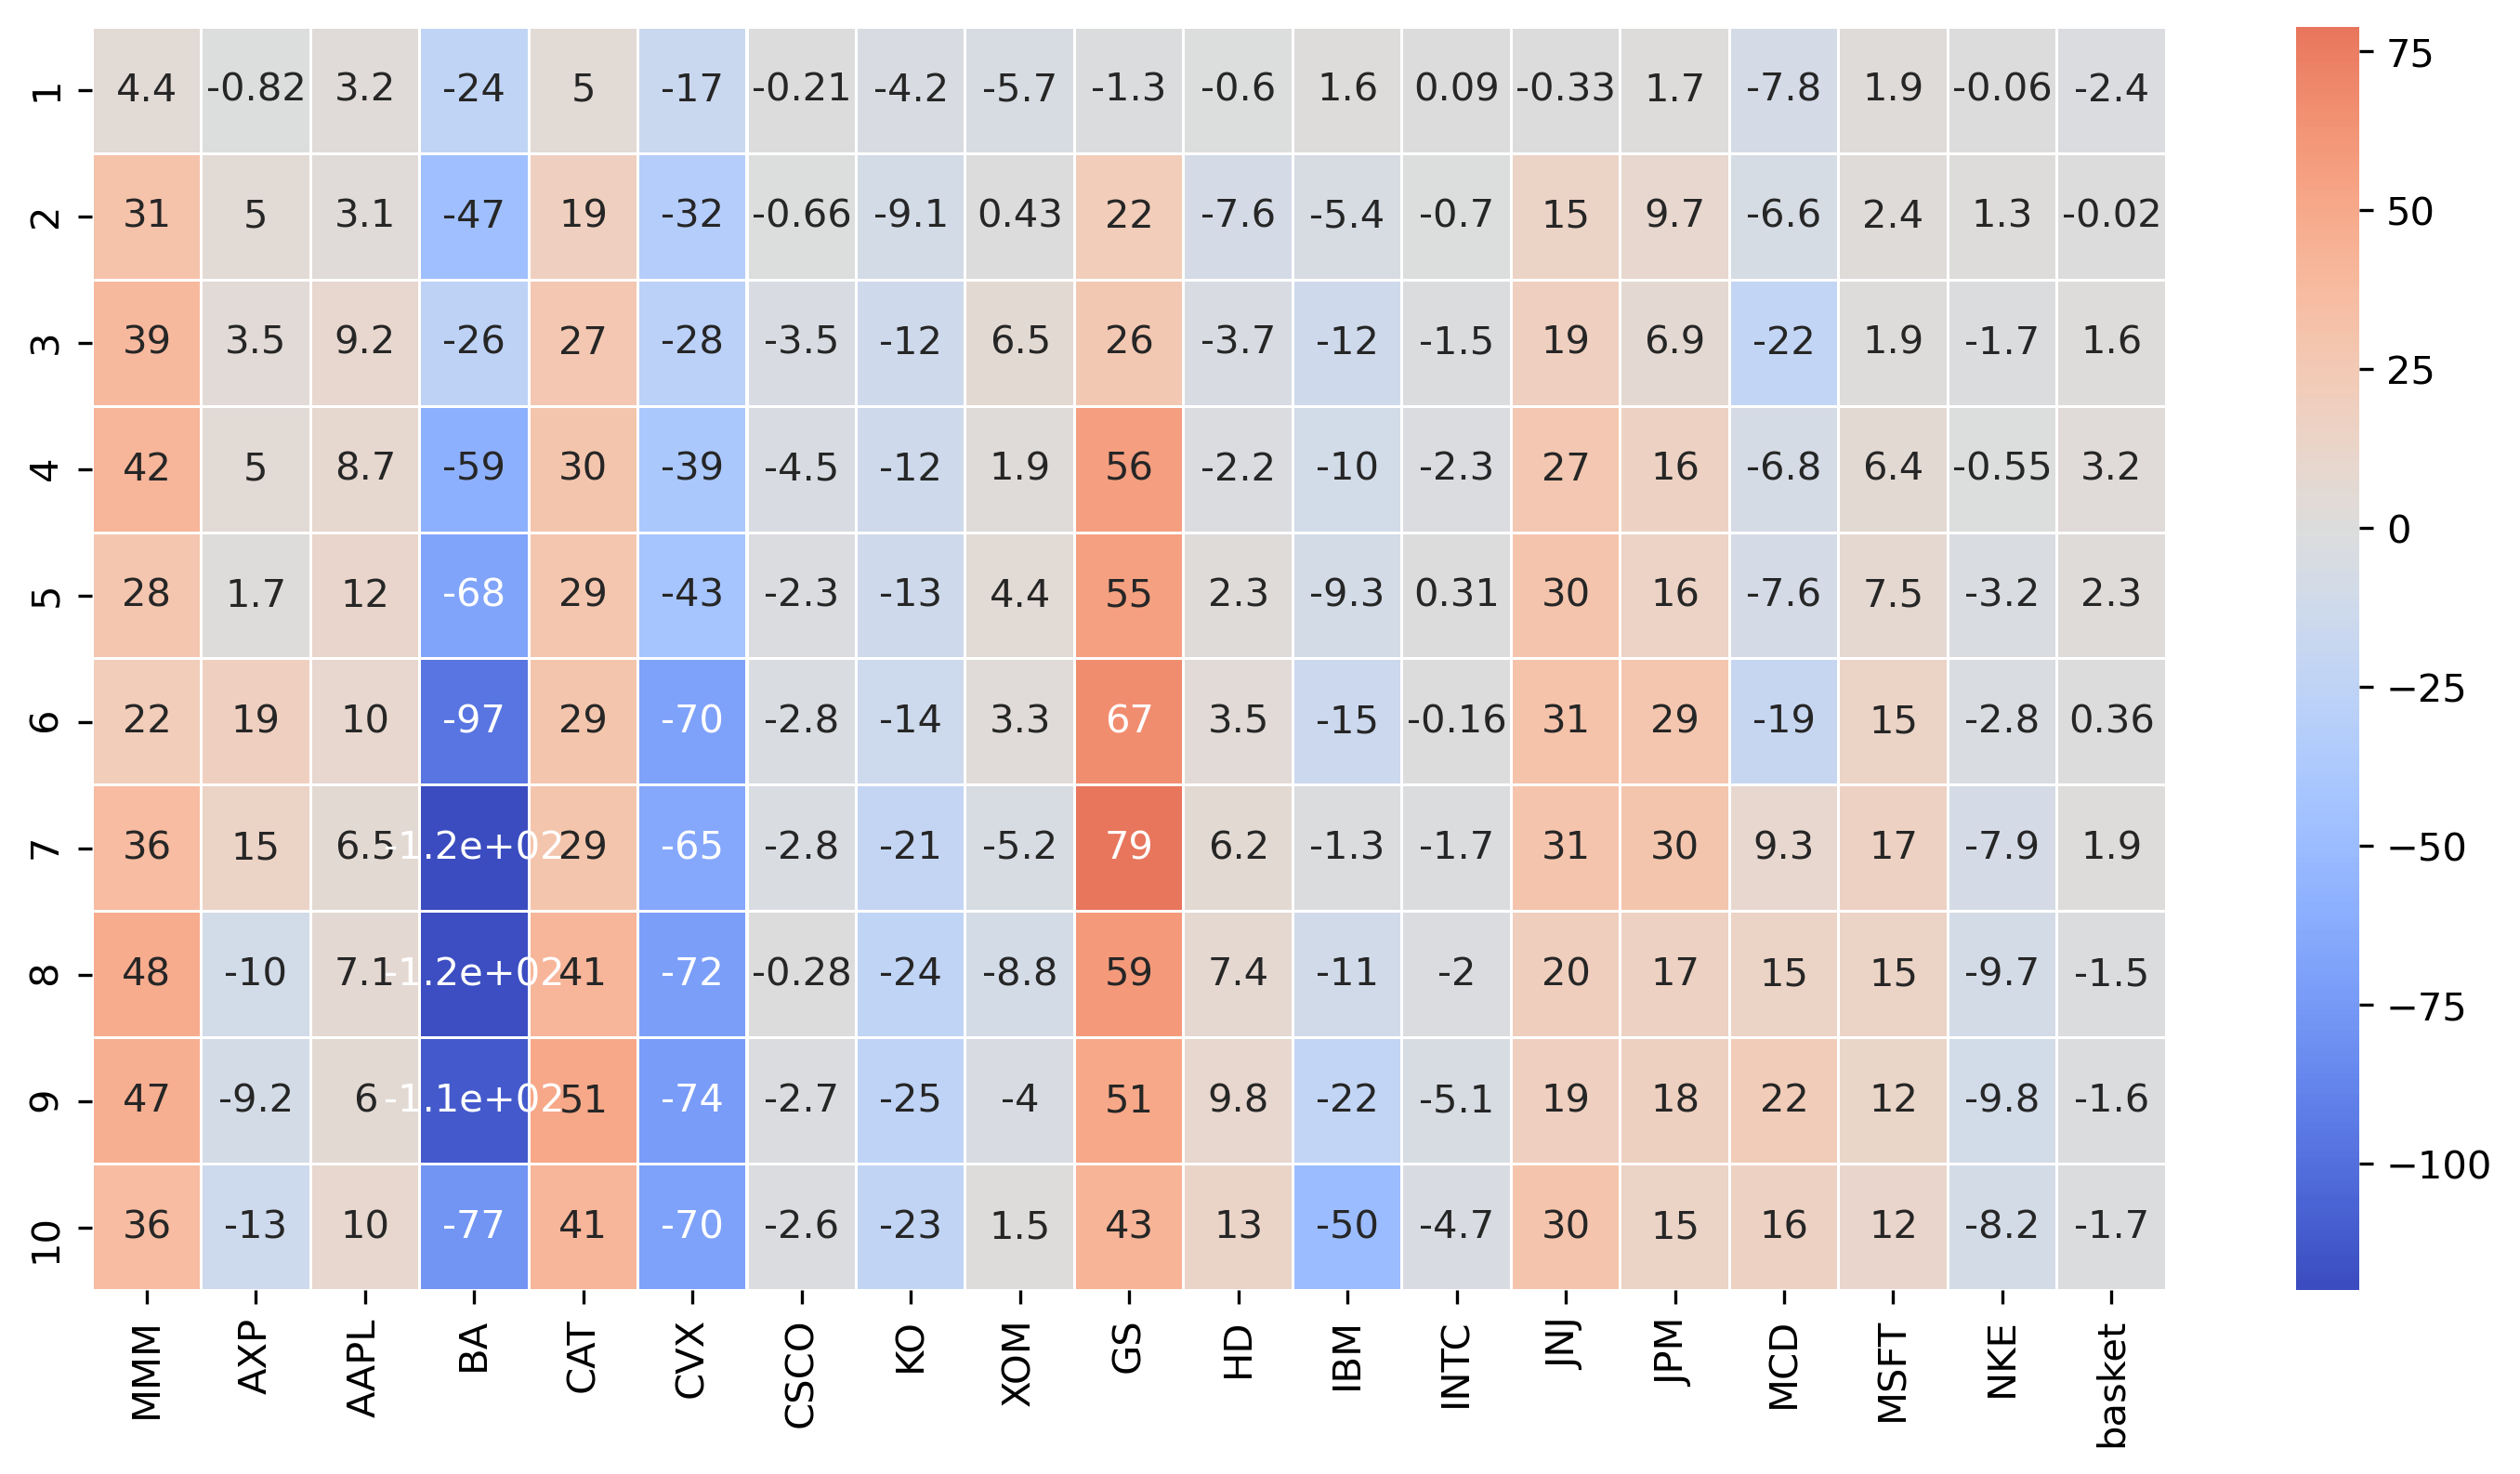

In [6]:
import seaborn as sns
plt.figure(figsize = [12,6], dpi = 300)
plt.xticks(rotation = 90)
ax = sns.heatmap(basket_results, annot=True, cmap="coolwarm", center = 0, linewidths=.5)

In [7]:
basket_results.iplot(title = "Pattern inertia")

# <span style="color:red">Esempio "Shooting Star"</span>

Pattern analysis on: MMM

Occurrences: 6 

DatetimeIndex(['2010-03-19', '2010-04-30', '2011-01-27', '2013-06-17',
               '2013-12-20', '2018-09-10'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.01 average of 0.0 with 2 winning trades and 4 loosing trades
After: 2 days: 7.43 average of 1.24 with 5 winning trades and 1 loosing trades
After: 3 days: 8.54 average of 1.42 with 4 winning trades and 2 loosing trades
After: 4 days: 10.91 average of 1.82 with 5 winning trades and 1 loosing trades
After: 5 days: 12.62 average of 2.1 with 5 winning trades and 1 loosing trades
After: 6 days: 5.01 average of 0.84 with 4 winning trades and 2 loosing trades
After: 7 days: 1.61 average of 0.27 with 3 winning trades and 3 loosing trades
After: 8 days: -2.79 average of -0.46 with 2 winning trades and 4 loosing trades
After: 9 days: -2.88 average of -0.48 with 2 winning trades and 4 loosing trades
After: 10 days: 0.85 average of 0.14 with 2 winning trades and 

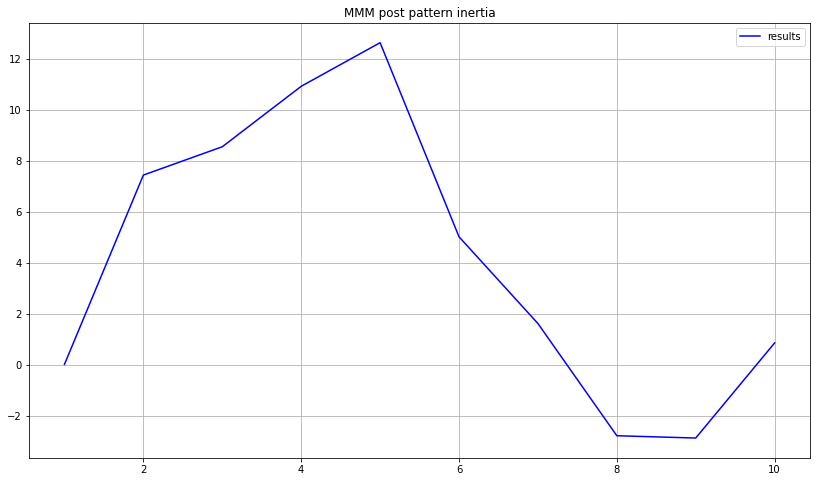


Pattern analysis on: AXP

Occurrences: 10 

DatetimeIndex(['2010-03-25', '2010-04-23', '2011-10-25', '2012-12-11',
               '2013-05-28', '2013-07-08', '2014-12-11', '2019-06-11',
               '2019-07-10', '2020-09-03'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 2.43 average of 0.24 with 5 winning trades and 5 loosing trades
After: 2 days: 5.18 average of 0.52 with 6 winning trades and 4 loosing trades
After: 3 days: 6.87 average of 0.69 with 8 winning trades and 2 loosing trades
After: 4 days: 3.96 average of 0.4 with 5 winning trades and 5 loosing trades
After: 5 days: 2.65 average of 0.26 with 3 winning trades and 7 loosing trades
After: 6 days: -5.03 average of -0.5 with 2 winning trades and 8 loosing trades
After: 7 days: -2.91 average of -0.29 with 3 winning trades and 7 loosing trades
After: 8 days: 0.02 average of 0.0 with 4 winning trades and 6 loosing trades
After: 9 days: -0.16 average of -0.02 with 3 winning trades and 7 loosin

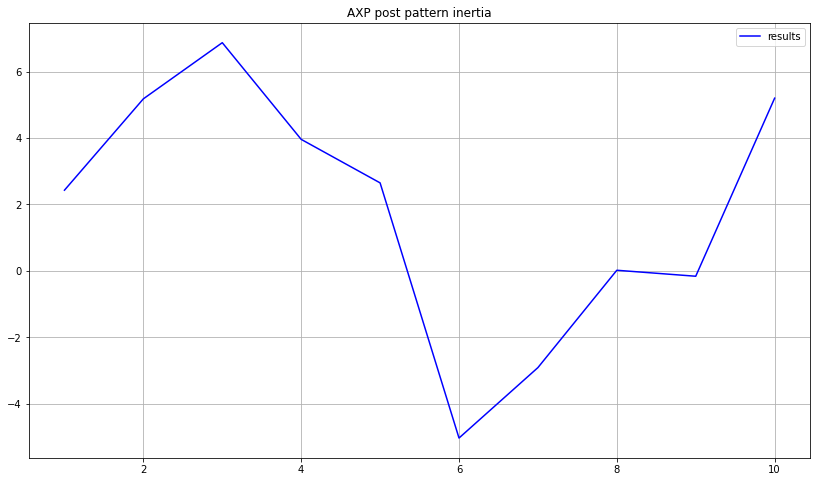


Pattern analysis on: AAPL

Occurrences: 8 

DatetimeIndex(['2014-11-17', '2015-10-21', '2016-02-29', '2018-05-07',
               '2019-04-09', '2019-06-10', '2019-10-01', '2019-10-07'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.74 average of -0.09 with 3 winning trades and 5 loosing trades
After: 2 days: -2.39 average of -0.3 with 2 winning trades and 6 loosing trades
After: 3 days: -4.98 average of -0.62 with 1 winning trades and 7 loosing trades
After: 4 days: -6.13 average of -0.77 with 1 winning trades and 7 loosing trades
After: 5 days: -7.0 average of -0.88 with 1 winning trades and 7 loosing trades
After: 6 days: -9.04 average of -1.13 with 0 winning trades and 8 loosing trades
After: 7 days: -10.16 average of -1.27 with 0 winning trades and 8 loosing trades
After: 8 days: -12.6 average of -1.58 with 0 winning trades and 8 loosing trades
After: 9 days: -12.85 average of -1.61 with 0 winning trades and 8 loosing trades
After: 10 days: -13

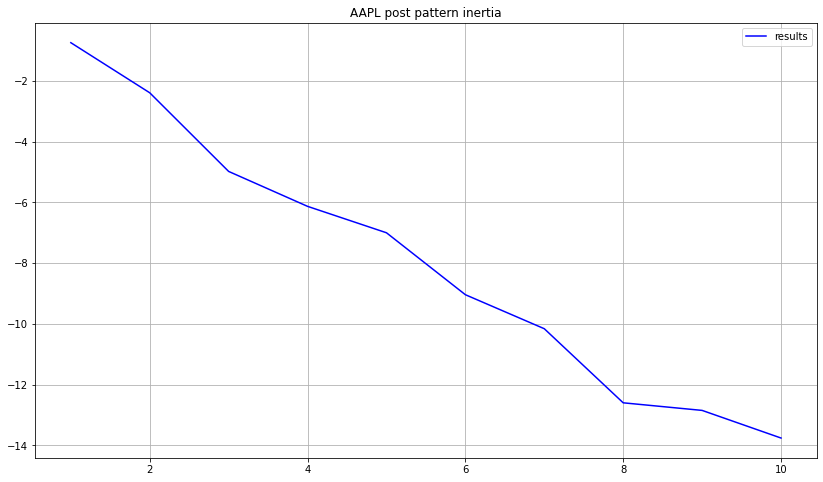


Pattern analysis on: BA

Occurrences: 10 

DatetimeIndex(['2010-03-19', '2012-10-11', '2015-09-17', '2016-07-27',
               '2017-02-28', '2017-06-20', '2017-07-12', '2017-09-22',
               '2018-02-27', '2018-05-10'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 8.5 average of 0.85 with 6 winning trades and 4 loosing trades
After: 2 days: 16.63 average of 1.66 with 4 winning trades and 6 loosing trades
After: 3 days: 21.18 average of 2.12 with 5 winning trades and 5 loosing trades
After: 4 days: 23.13 average of 2.31 with 6 winning trades and 4 loosing trades
After: 5 days: 22.13 average of 2.21 with 5 winning trades and 5 loosing trades
After: 6 days: 13.42 average of 1.34 with 5 winning trades and 5 loosing trades
After: 7 days: 4.29 average of 0.43 with 6 winning trades and 4 loosing trades
After: 8 days: 9.36 average of 0.94 with 6 winning trades and 4 loosing trades
After: 9 days: 8.0 average of 0.8 with 5 winning trades and 5 loosing 

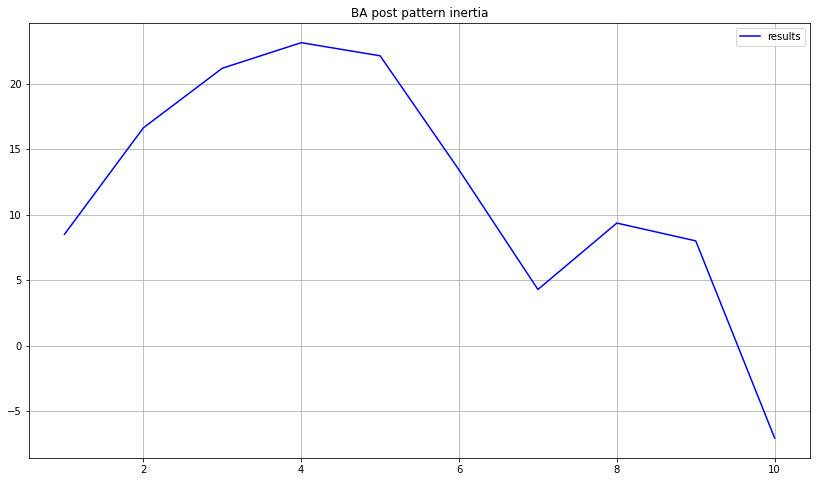


Pattern analysis on: CAT

Occurrences: 15 

DatetimeIndex(['2010-12-07', '2011-03-25', '2011-03-28', '2011-07-07',
               '2012-08-07', '2012-12-19', '2013-08-13', '2014-01-16',
               '2016-10-03', '2017-07-12', '2017-08-25', '2017-10-26',
               '2018-04-17', '2018-05-21', '2020-04-07'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -1.72 average of -0.11 with 9 winning trades and 6 loosing trades
After: 2 days: -1.18 average of -0.08 with 8 winning trades and 7 loosing trades
After: 3 days: 13.1 average of 0.87 with 10 winning trades and 5 loosing trades
After: 4 days: 11.3 average of 0.75 with 9 winning trades and 6 loosing trades
After: 5 days: 28.5 average of 1.9 with 10 winning trades and 5 loosing trades
After: 6 days: 20.23 average of 1.35 with 9 winning trades and 6 loosing trades
After: 7 days: 18.11 average of 1.21 with 8 winning trades and 7 loosing trades
After: 8 days: 14.97 average of 1.0 with 7 winning trades an

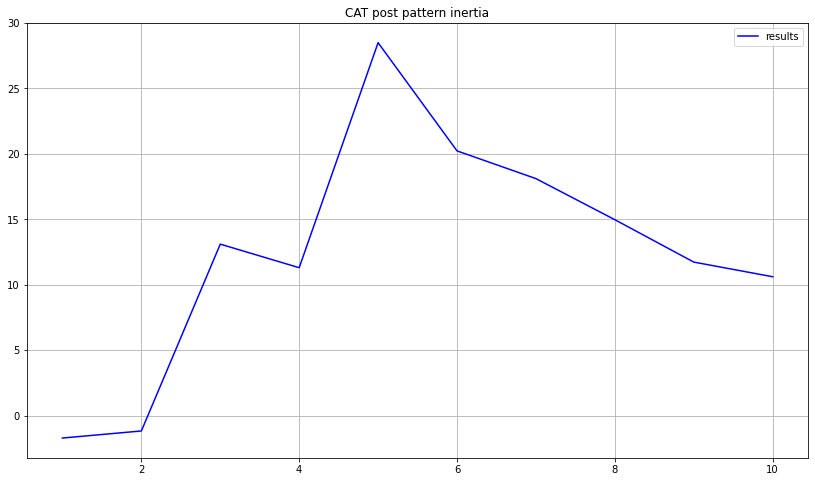


Pattern analysis on: CVX

Occurrences: 8 

DatetimeIndex(['2012-03-14', '2012-07-31', '2012-12-12', '2014-03-21',
               '2016-12-05', '2017-09-14', '2018-05-09', '2018-12-03'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 4.54 average of 0.57 with 6 winning trades and 2 loosing trades
After: 2 days: 2.46 average of 0.31 with 4 winning trades and 4 loosing trades
After: 3 days: -3.32 average of -0.42 with 1 winning trades and 7 loosing trades
After: 4 days: -2.74 average of -0.34 with 2 winning trades and 6 loosing trades
After: 5 days: -4.64 average of -0.58 with 3 winning trades and 5 loosing trades
After: 6 days: -4.29 average of -0.54 with 3 winning trades and 5 loosing trades
After: 7 days: -3.17 average of -0.4 with 3 winning trades and 5 loosing trades
After: 8 days: -4.86 average of -0.61 with 3 winning trades and 5 loosing trades
After: 9 days: -1.75 average of -0.22 with 4 winning trades and 4 loosing trades
After: 10 days: 2.04 aver

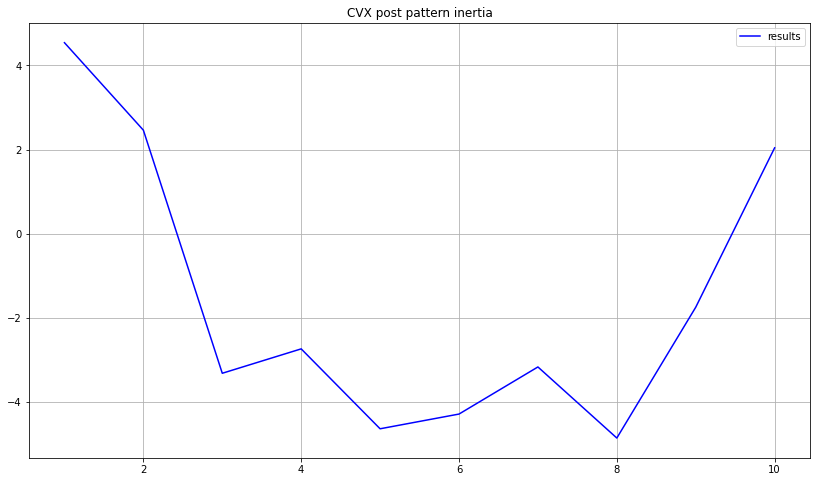


Pattern analysis on: CSCO

Occurrences: 15 

DatetimeIndex(['2010-07-29', '2011-02-07', '2011-09-14', '2014-04-03',
               '2014-12-23', '2014-12-24', '2015-07-24', '2015-08-13',
               '2016-11-14', '2016-11-16', '2016-12-14', '2018-01-04',
               '2018-01-24', '2018-09-27', '2019-12-16'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.55 average of -0.04 with 5 winning trades and 10 loosing trades
After: 2 days: -2.83 average of -0.19 with 3 winning trades and 12 loosing trades
After: 3 days: 0.74 average of 0.05 with 5 winning trades and 10 loosing trades
After: 4 days: 2.53 average of 0.17 with 9 winning trades and 6 loosing trades
After: 5 days: 6.02 average of 0.4 with 10 winning trades and 5 loosing trades
After: 6 days: 7.73 average of 0.52 with 10 winning trades and 5 loosing trades
After: 7 days: 10.54 average of 0.7 with 11 winning trades and 4 loosing trades
After: 8 days: 11.73 average of 0.78 with 11 winning trad

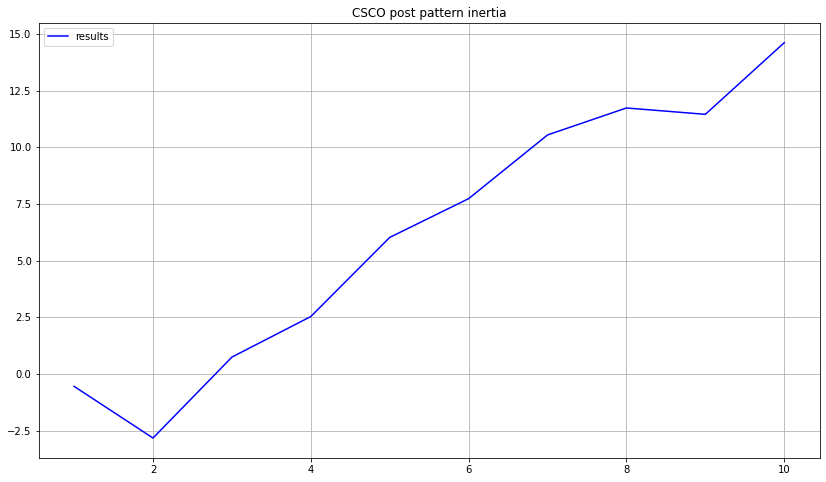


Pattern analysis on: KO

Occurrences: 7 

DatetimeIndex(['2013-11-25', '2014-04-10', '2015-05-11', '2015-10-06',
               '2019-06-12', '2020-07-15', '2020-07-28'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.7 average of 0.1 with 6 winning trades and 1 loosing trades
After: 2 days: -0.68 average of -0.1 with 4 winning trades and 3 loosing trades
After: 3 days: -1.03 average of -0.15 with 4 winning trades and 3 loosing trades
After: 4 days: -1.24 average of -0.18 with 3 winning trades and 4 loosing trades
After: 5 days: -3.24 average of -0.46 with 3 winning trades and 4 loosing trades
After: 6 days: -4.18 average of -0.6 with 2 winning trades and 5 loosing trades
After: 7 days: -4.24 average of -0.61 with 2 winning trades and 5 loosing trades
After: 8 days: -5.55 average of -0.79 with 2 winning trades and 5 loosing trades
After: 9 days: -4.87 average of -0.7 with 2 winning trades and 5 loosing trades
After: 10 days: -4.12 average of -0.59 wit

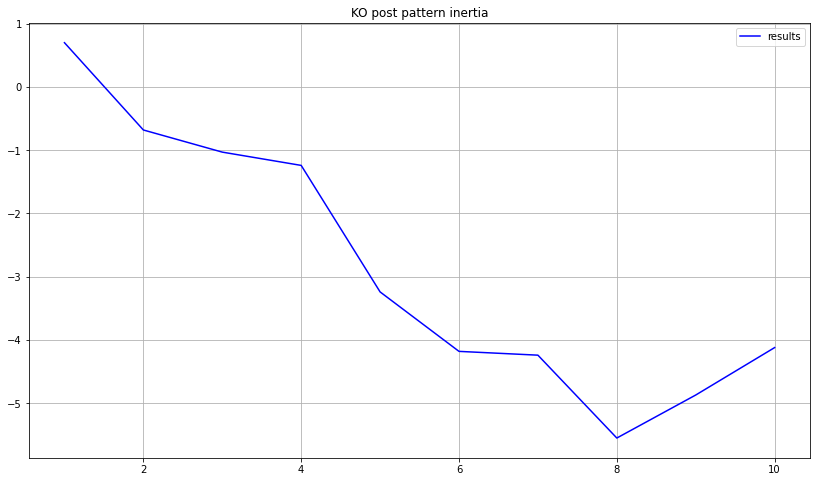


Pattern analysis on: XOM

Occurrences: 5 

DatetimeIndex(['2010-04-29', '2013-10-31', '2014-04-29', '2015-04-20',
               '2016-04-21'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.02 average of -0.0 with 2 winning trades and 3 loosing trades
After: 2 days: -1.75 average of -0.35 with 1 winning trades and 4 loosing trades
After: 3 days: -1.25 average of -0.25 with 1 winning trades and 4 loosing trades
After: 4 days: -3.34 average of -0.67 with 2 winning trades and 3 loosing trades
After: 5 days: 0.83 average of 0.17 with 2 winning trades and 3 loosing trades
After: 6 days: -1.35 average of -0.27 with 1 winning trades and 4 loosing trades
After: 7 days: -3.12 average of -0.62 with 1 winning trades and 4 loosing trades
After: 8 days: -0.17 average of -0.03 with 2 winning trades and 3 loosing trades
After: 9 days: -2.13 average of -0.43 with 1 winning trades and 4 loosing trades
After: 10 days: -3.08 average of -0.62 with 1 winning trades and 

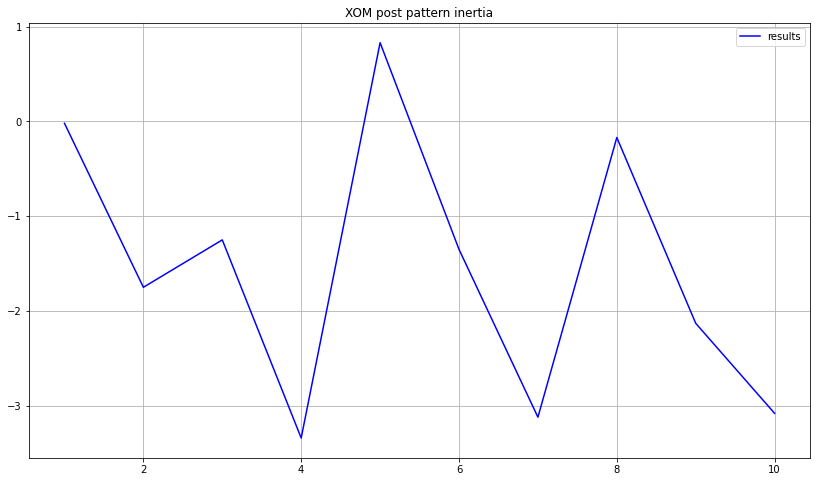


Pattern analysis on: GS

Occurrences: 9 

DatetimeIndex(['2010-02-23', '2011-04-07', '2011-10-19', '2012-01-23',
               '2013-05-16', '2017-08-08', '2019-12-16', '2020-01-07',
               '2020-07-16'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -2.91 average of -0.32 with 3 winning trades and 6 loosing trades
After: 2 days: -1.81 average of -0.2 with 4 winning trades and 5 loosing trades
After: 3 days: -2.64 average of -0.29 with 5 winning trades and 4 loosing trades
After: 4 days: -0.14 average of -0.02 with 6 winning trades and 3 loosing trades
After: 5 days: 2.25 average of 0.25 with 4 winning trades and 5 loosing trades
After: 6 days: -6.02 average of -0.67 with 4 winning trades and 5 loosing trades
After: 7 days: -17.15 average of -1.91 with 3 winning trades and 6 loosing trades
After: 8 days: -13.12 average of -1.46 with 3 winning trades and 6 loosing trades
After: 9 days: -11.21 average of -1.25 with 4 winning trades and 5 loosing

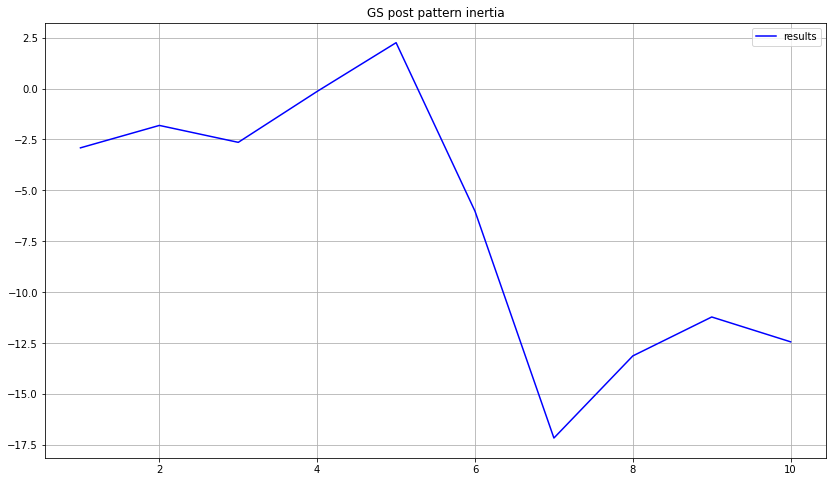


Pattern analysis on: HD

Occurrences: 16 

DatetimeIndex(['2010-04-26', '2010-11-16', '2011-05-17', '2011-07-21',
               '2011-09-16', '2011-11-16', '2012-02-15', '2012-09-25',
               '2013-04-11', '2014-12-12', '2014-12-31', '2015-01-28',
               '2015-03-24', '2017-03-24', '2019-03-22', '2020-01-22'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 0.31 average of 0.02 with 8 winning trades and 8 loosing trades
After: 2 days: 10.82 average of 0.68 with 9 winning trades and 7 loosing trades
After: 3 days: 9.55 average of 0.6 with 12 winning trades and 4 loosing trades
After: 4 days: -0.6 average of -0.04 with 9 winning trades and 7 loosing trades
After: 5 days: -5.81 average of -0.36 with 8 winning trades and 8 loosing trades
After: 6 days: -10.84 average of -0.68 with 9 winning trades and 7 loosing trades
After: 7 days: -4.82 average of -0.3 with 10 winning trades and 6 loosing trades
After: 8 days: -11.13 average of -0.7 with 9 

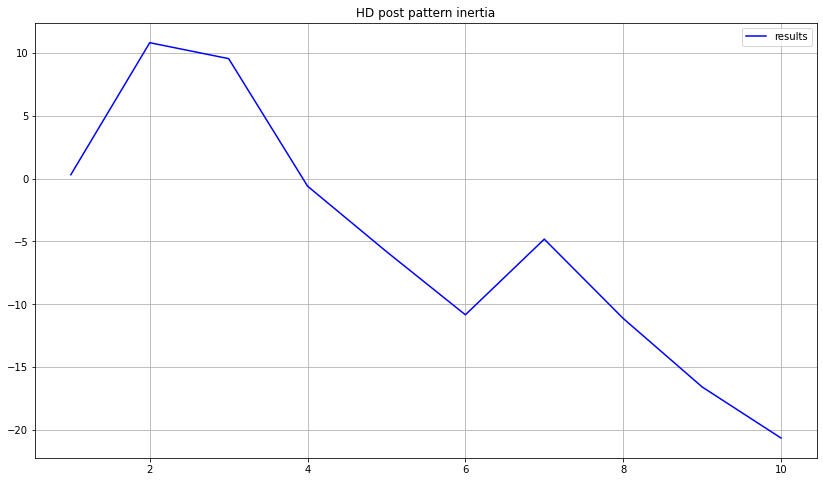


Pattern analysis on: IBM

Occurrences: 18 

DatetimeIndex(['2010-03-24', '2010-03-25', '2010-04-16', '2011-04-29',
               '2011-09-28', '2011-10-12', '2011-12-05', '2013-05-31',
               '2013-12-20', '2014-02-19', '2014-04-10', '2014-07-17',
               '2016-09-29', '2016-12-15', '2018-03-16', '2018-06-07',
               '2018-09-12', '2019-07-01'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -8.15 average of -0.45 with 5 winning trades and 13 loosing trades
After: 2 days: -2.59 average of -0.14 with 10 winning trades and 8 loosing trades
After: 3 days: 7.01 average of 0.39 with 9 winning trades and 9 loosing trades
After: 4 days: 18.1 average of 1.01 with 10 winning trades and 8 loosing trades
After: 5 days: 24.74 average of 1.37 with 12 winning trades and 6 loosing trades
After: 6 days: 10.22 average of 0.57 with 8 winning trades and 10 loosing trades
After: 7 days: 9.06 average of 0.5 with 11 winning trades and 7 loosing trades

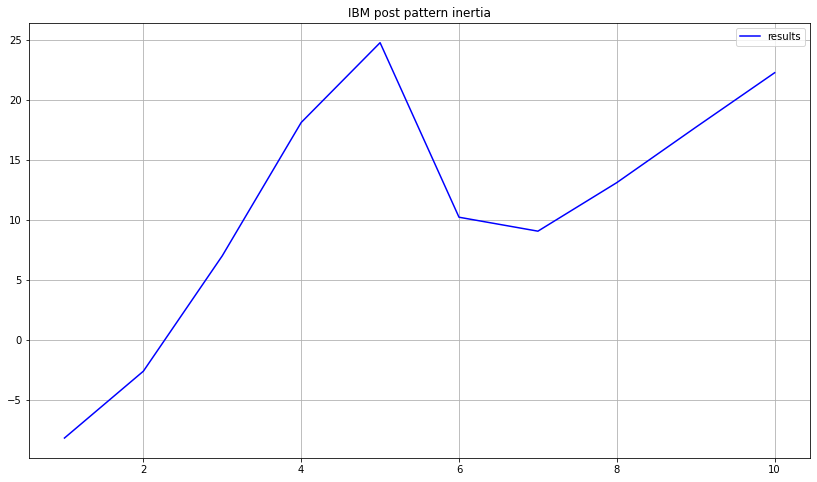


Pattern analysis on: INTC

Occurrences: 14 

DatetimeIndex(['2010-07-13', '2010-10-11', '2012-03-14', '2012-04-17',
               '2013-05-30', '2013-05-31', '2014-03-27', '2016-06-22',
               '2017-04-03', '2018-04-18', '2019-02-06', '2019-10-11',
               '2019-12-23', '2020-05-19'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -2.07 average of -0.15 with 4 winning trades and 10 loosing trades
After: 2 days: -0.4 average of -0.03 with 5 winning trades and 9 loosing trades
After: 3 days: 1.63 average of 0.12 with 7 winning trades and 7 loosing trades
After: 4 days: 0.92 average of 0.07 with 8 winning trades and 6 loosing trades
After: 5 days: -1.16 average of -0.08 with 8 winning trades and 6 loosing trades
After: 6 days: -4.29 average of -0.31 with 3 winning trades and 11 loosing trades
After: 7 days: -6.77 average of -0.48 with 5 winning trades and 9 loosing trades
After: 8 days: -3.79 average of -0.27 with 5 winning trades and 9 loo

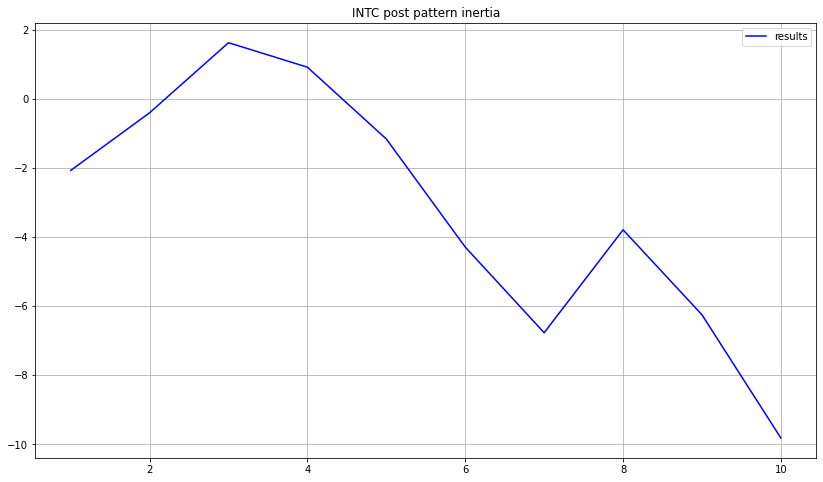


Pattern analysis on: JNJ

Occurrences: 8 

DatetimeIndex(['2010-11-15', '2012-02-23', '2013-05-22', '2013-10-15',
               '2018-12-04', '2019-04-16', '2020-02-04', '2020-07-21'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -3.23 average of -0.4 with 3 winning trades and 5 loosing trades
After: 2 days: -1.27 average of -0.16 with 5 winning trades and 3 loosing trades
After: 3 days: -0.23 average of -0.03 with 2 winning trades and 6 loosing trades
After: 4 days: -0.08 average of -0.01 with 2 winning trades and 6 loosing trades
After: 5 days: -0.8 average of -0.1 with 3 winning trades and 5 loosing trades
After: 6 days: 2.08 average of 0.26 with 5 winning trades and 3 loosing trades
After: 7 days: 15.54 average of 1.94 with 5 winning trades and 3 loosing trades
After: 8 days: 23.41 average of 2.93 with 6 winning trades and 2 loosing trades
After: 9 days: 20.73 average of 2.59 with 6 winning trades and 2 loosing trades
After: 10 days: 21.4 average

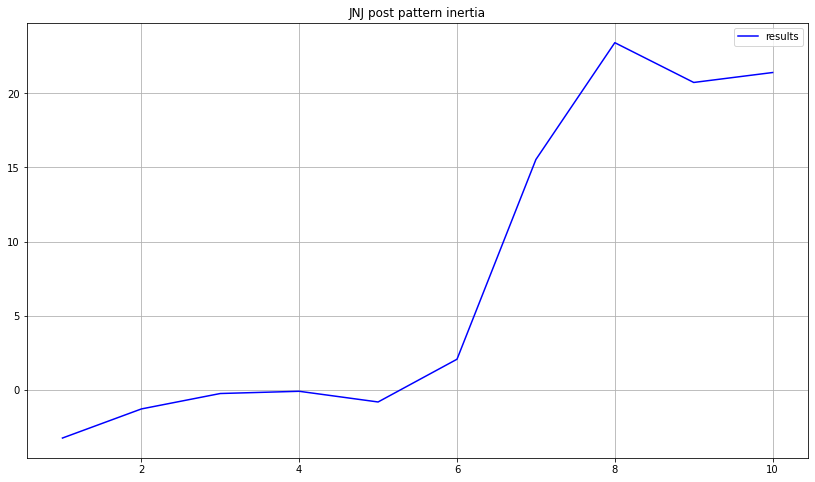


Pattern analysis on: JPM

Occurrences: 10 

DatetimeIndex(['2010-03-25', '2010-03-26', '2013-03-05', '2013-05-16',
               '2014-01-16', '2014-09-22', '2014-09-23', '2015-05-05',
               '2017-08-08', '2019-02-25'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.98 average of -0.1 with 4 winning trades and 6 loosing trades
After: 2 days: 0.49 average of 0.05 with 6 winning trades and 4 loosing trades
After: 3 days: 2.53 average of 0.25 with 7 winning trades and 3 loosing trades
After: 4 days: 0.88 average of 0.09 with 7 winning trades and 3 loosing trades
After: 5 days: 2.56 average of 0.26 with 5 winning trades and 5 loosing trades
After: 6 days: 2.83 average of 0.28 with 5 winning trades and 5 loosing trades
After: 7 days: 3.12 average of 0.31 with 5 winning trades and 5 loosing trades
After: 8 days: 4.62 average of 0.46 with 5 winning trades and 5 loosing trades
After: 9 days: 1.24 average of 0.12 with 6 winning trades and 4 loosing 

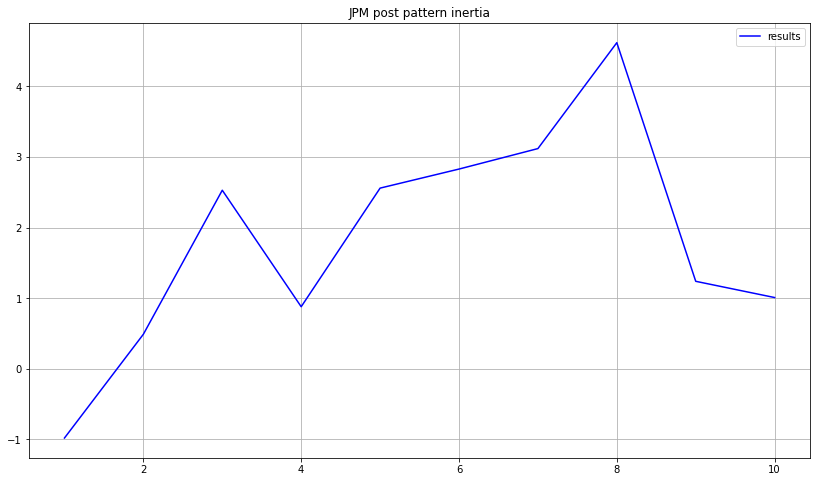


Pattern analysis on: MCD

Occurrences: 10 

DatetimeIndex(['2010-09-09', '2010-10-20', '2010-10-29', '2011-07-25',
               '2011-10-25', '2011-12-08', '2014-02-19', '2017-02-16',
               '2017-03-17', '2020-08-11'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: -0.42 average of -0.04 with 5 winning trades and 5 loosing trades
After: 2 days: -3.01 average of -0.3 with 3 winning trades and 7 loosing trades
After: 3 days: -2.6 average of -0.26 with 2 winning trades and 8 loosing trades
After: 4 days: -5.06 average of -0.51 with 2 winning trades and 8 loosing trades
After: 5 days: -5.13 average of -0.51 with 3 winning trades and 7 loosing trades
After: 6 days: -0.17 average of -0.02 with 4 winning trades and 6 loosing trades
After: 7 days: -2.8 average of -0.28 with 4 winning trades and 6 loosing trades
After: 8 days: -6.49 average of -0.65 with 4 winning trades and 6 loosing trades
After: 9 days: -10.19 average of -1.02 with 3 winning trades

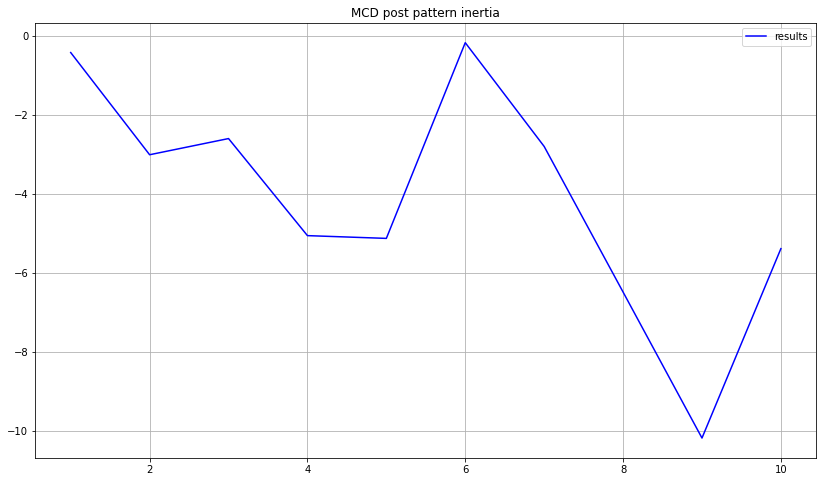


Pattern analysis on: MSFT

Occurrences: 11 

DatetimeIndex(['2010-03-25', '2010-11-08', '2011-04-05', '2013-04-19',
               '2014-02-21', '2015-12-02', '2016-03-30', '2017-09-18',
               '2020-01-21', '2020-05-05', '2020-06-23'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 5.37 average of 0.49 with 4 winning trades and 7 loosing trades
After: 2 days: -0.35 average of -0.03 with 5 winning trades and 6 loosing trades
After: 3 days: 4.35 average of 0.4 with 6 winning trades and 5 loosing trades
After: 4 days: 4.04 average of 0.37 with 6 winning trades and 5 loosing trades
After: 5 days: 1.66 average of 0.15 with 6 winning trades and 5 loosing trades
After: 6 days: 1.02 average of 0.09 with 7 winning trades and 4 loosing trades
After: 7 days: -6.12 average of -0.56 with 7 winning trades and 4 loosing trades
After: 8 days: -11.2 average of -1.02 with 6 winning trades and 5 loosing trades
After: 9 days: -16.28 average of -1.48 with 6 winning

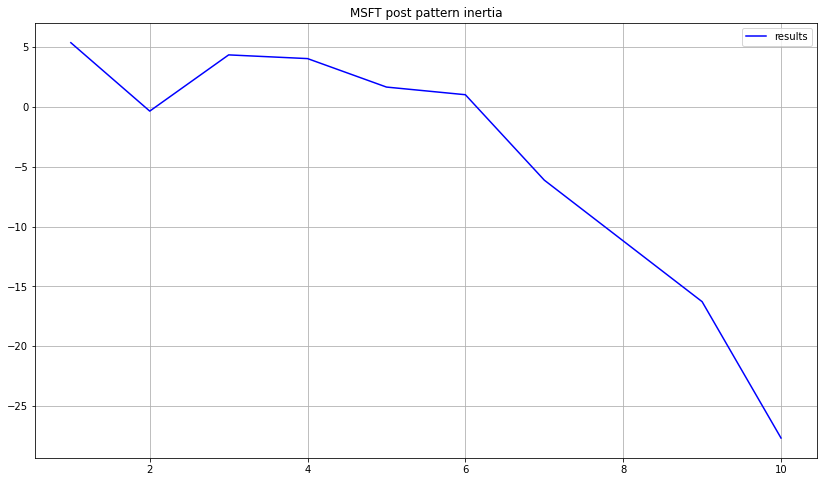


Pattern analysis on: NKE

Occurrences: 8 

DatetimeIndex(['2010-12-01', '2011-09-27', '2012-03-20', '2013-02-08',
               '2018-05-22', '2018-06-07', '2019-07-09', '2020-05-19'],
              dtype='datetime64[ns]', name='Date', freq=None) 

After: 1 days: 1.77 average of 0.22 with 5 winning trades and 3 loosing trades
After: 2 days: -0.8 average of -0.1 with 6 winning trades and 2 loosing trades
After: 3 days: 0.85 average of 0.11 with 5 winning trades and 3 loosing trades
After: 4 days: -0.44 average of -0.06 with 6 winning trades and 2 loosing trades
After: 5 days: -5.41 average of -0.68 with 5 winning trades and 3 loosing trades
After: 6 days: -3.77 average of -0.47 with 5 winning trades and 3 loosing trades
After: 7 days: -4.93 average of -0.62 with 5 winning trades and 3 loosing trades
After: 8 days: -5.21 average of -0.65 with 5 winning trades and 3 loosing trades
After: 9 days: -7.27 average of -0.91 with 4 winning trades and 4 loosing trades
After: 10 days: -10.77 ave

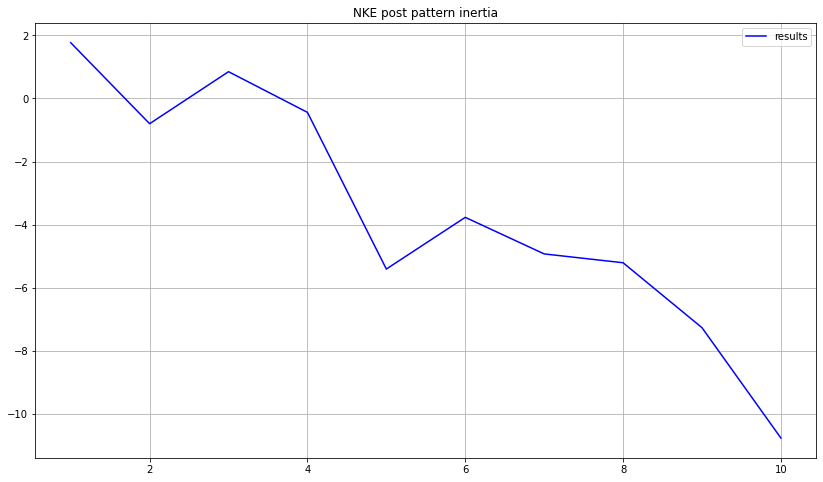


Basket analysis:
Positive inertia after 1 bars: ['MMM', 'AXP', 'BA', 'CVX', 'KO', 'HD', 'MSFT', 'NKE']
Positive inertia after 2 bars: ['MMM', 'AXP', 'BA', 'CVX', 'HD', 'JPM']
Positive inertia after 3 bars: ['MMM', 'AXP', 'BA', 'CAT', 'CSCO', 'HD', 'IBM', 'INTC', 'JPM', 'MSFT', 'NKE']
Positive inertia after 4 bars: ['MMM', 'AXP', 'BA', 'CAT', 'CSCO', 'IBM', 'INTC', 'JPM', 'MSFT']
Positive inertia after 5 bars: ['MMM', 'AXP', 'BA', 'CAT', 'CSCO', 'XOM', 'GS', 'IBM', 'JPM', 'MSFT']
Positive inertia after 6 bars: ['MMM', 'BA', 'CAT', 'CSCO', 'IBM', 'JNJ', 'JPM', 'MSFT']
Positive inertia after 7 bars: ['MMM', 'BA', 'CAT', 'CSCO', 'IBM', 'JNJ', 'JPM']
Positive inertia after 8 bars: ['AXP', 'BA', 'CAT', 'CSCO', 'IBM', 'JNJ', 'JPM']
Positive inertia after 9 bars: ['BA', 'CAT', 'CSCO', 'IBM', 'JNJ', 'JPM']
Positive inertia after 10 bars: ['MMM', 'AXP', 'CAT', 'CVX', 'CSCO', 'IBM', 'JNJ', 'JPM']


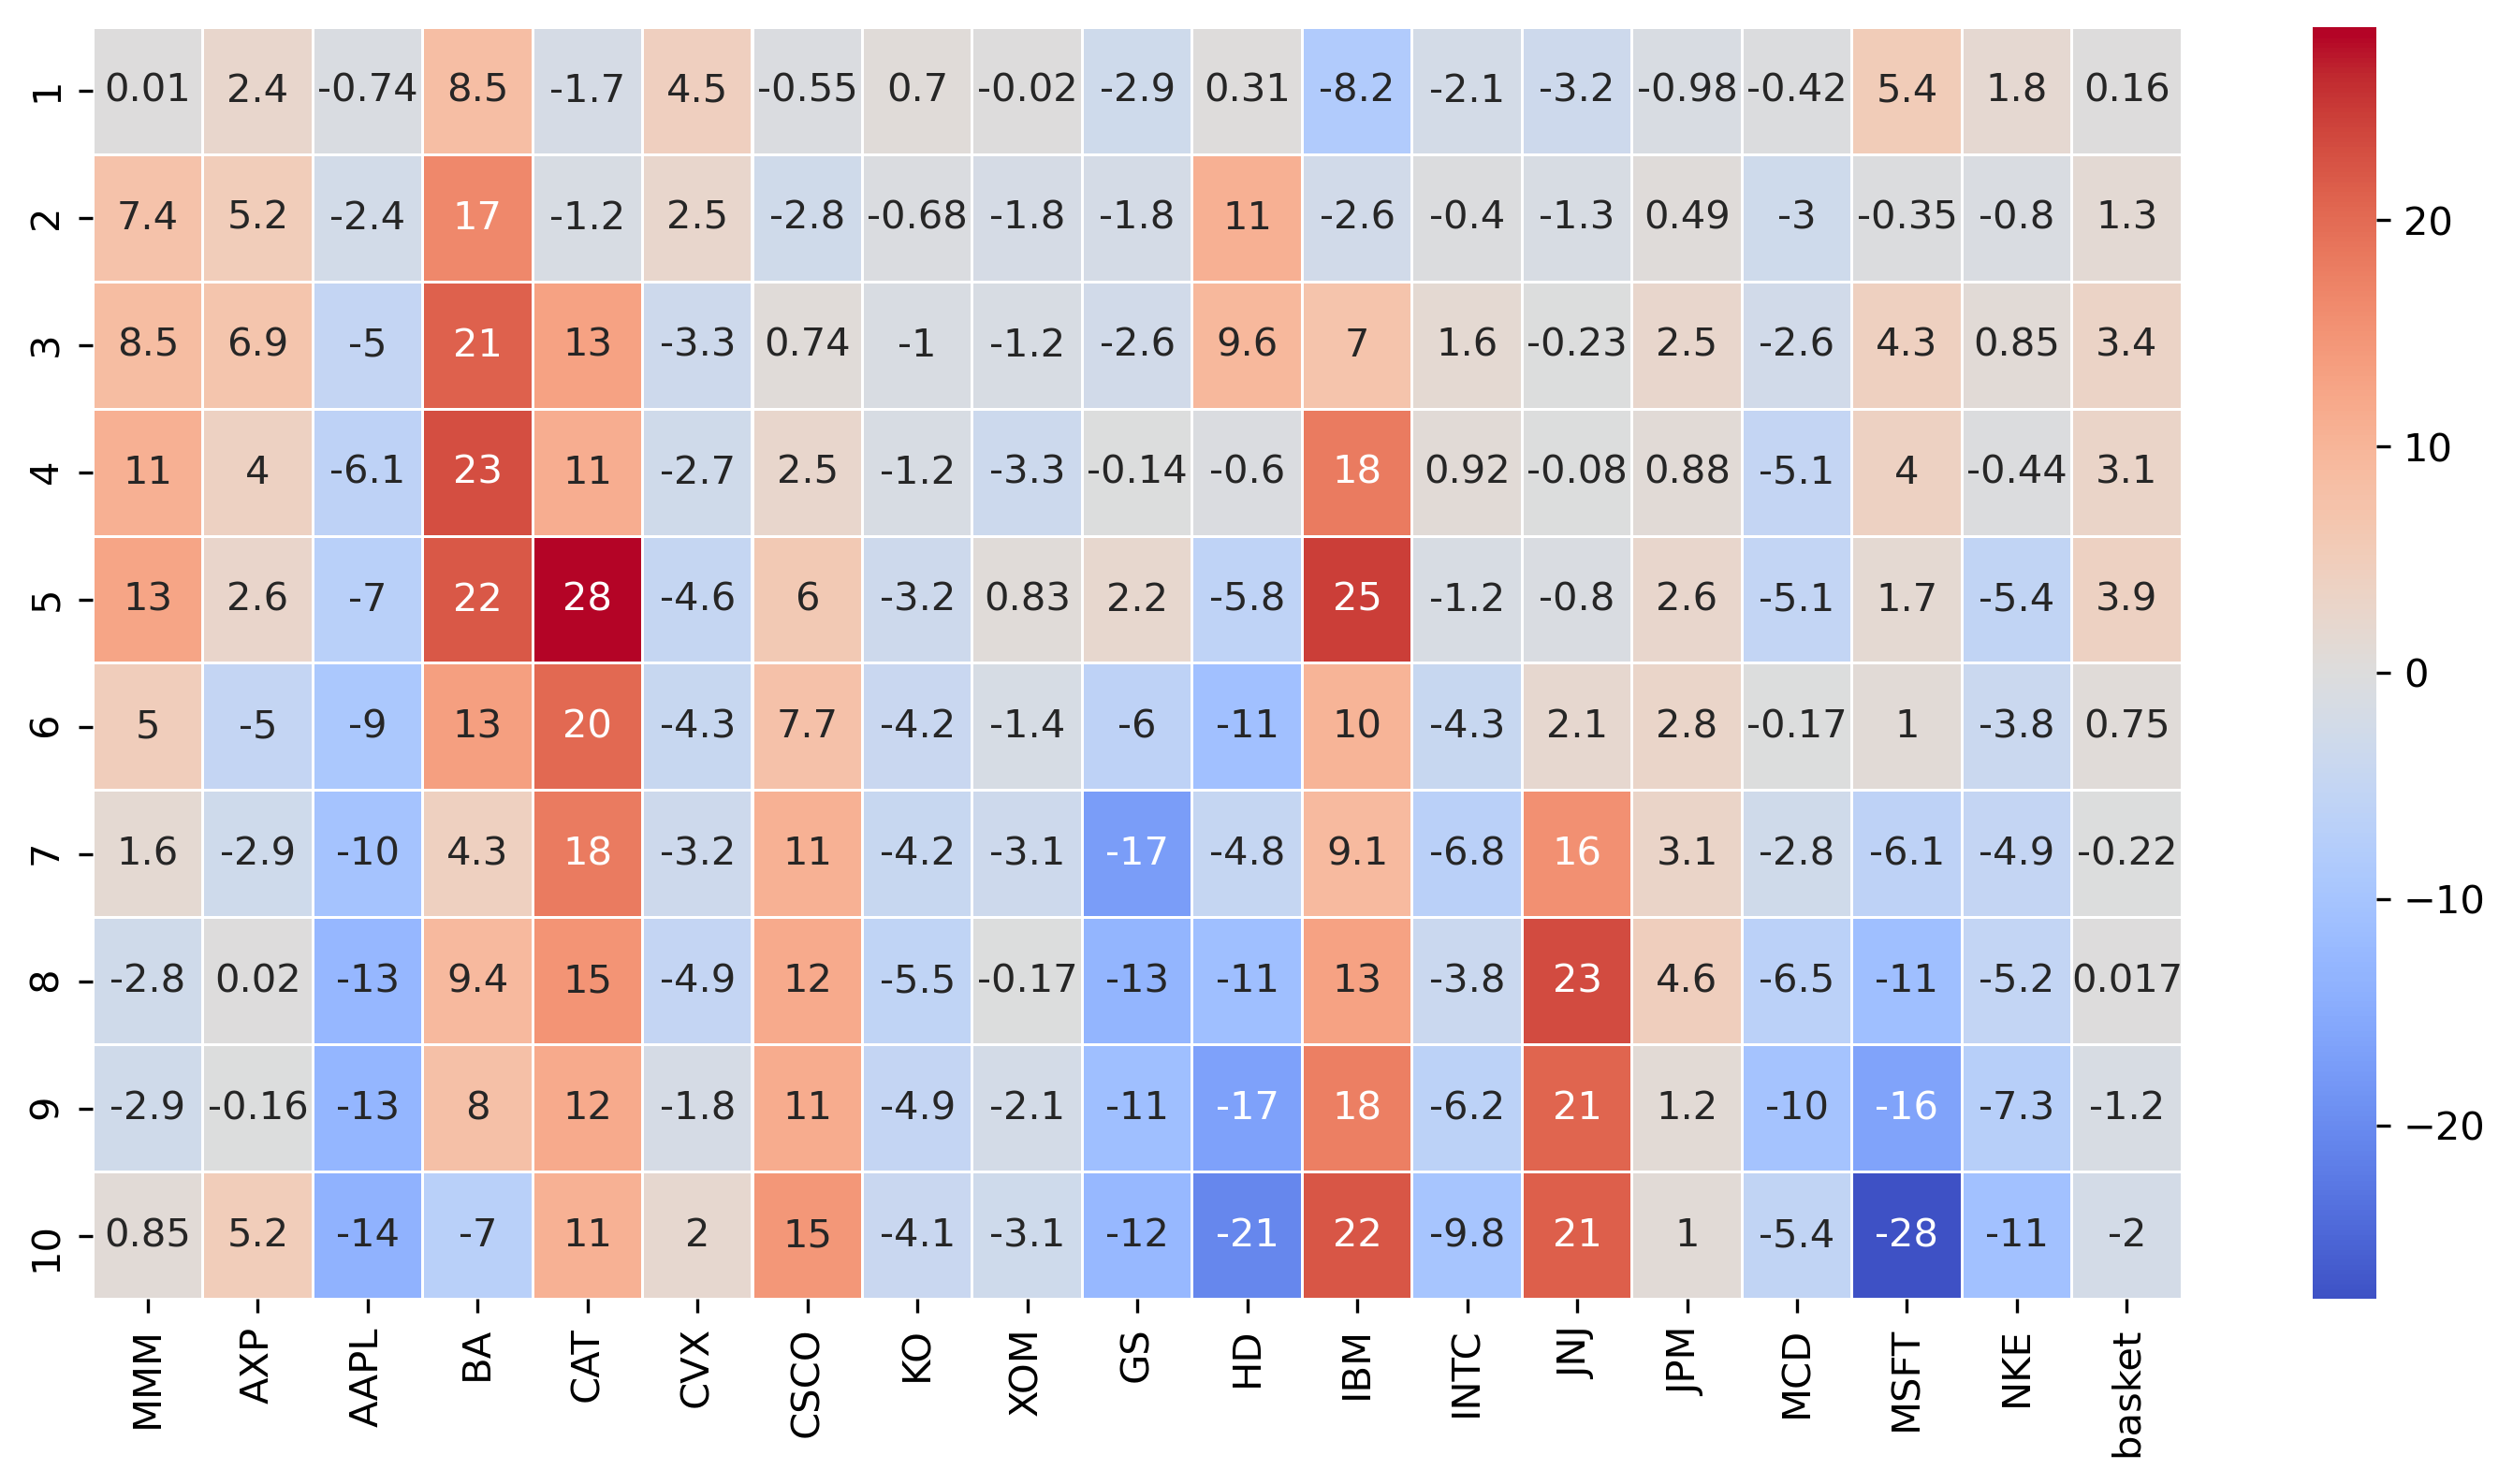

In [8]:
basket_results = pd.DataFrame(index = range(1,days_after + 1))

for ticker in tickerlist.split(","):

    print("Pattern analysis on: " + ticker + "\n")

    dataset = create_asset_dataset(matrix)
    
    pattern = (dataset.high > dataset.BBU) & (dataset.close < dataset.BBU) & \
              (dataset.close_pos < 30) & (dataset.open_pos < 30) & (dataset.range_perc > 1)
    
    results = pattern_stats(dataset, pattern, "short", days_after, ticker)
    
    if show_patterns == True:
        plot_patterns(dataset,results[0])
        
    basket_results[ticker] = results[1]
        
    print("")
    
print("Basket analysis:")
positive_effect(basket_results)
    
basket_results["basket"] = basket_results.mean(axis = 1)
basket_results

plt.figure(figsize = [12,6], dpi = 300)
plt.xticks(rotation = 90)
ax = sns.heatmap(basket_results, annot=True, cmap="coolwarm", center = 0, linewidths=.5)

In [9]:
basket_results.iplot(title = "Pattern inertia")